# Sediments & Granularity Investigations

In [3]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

    
pd.set_option('display.precision', 3)

In [4]:
data_path = '../Final_Data_Sets/'
data_file_name = 'PIBN_Granulometry_NCDOT_CSI_2012-2020.csv'

plot_path = '../Final_Plots/sand_plots/'

In [5]:
def load_data(path, name):
    df_ = pd.read_csv(path+name)
    
    # create a new iso date time object field from existing sampling date:
    df_['iso_date'] = pd.to_datetime(df_['sampling_date'])

    # to balance the design remove transects T-12 thru T-16 from the data:
    # we could have done this before the DOT to CSI label remapping but it would
    # have required additional code to detect the NT72,3,and 4 transects, too.
    df_.query("CSI_transect != ['T12','T13','T14','T15','T16']", inplace=True)
    
    # create new survey field from existing sampling date:
    yr = df_['sampling_date'].str[0:4]
    df_['year'] = yr
    mon = df_['sampling_date'].str[5:7]
    df_['survey'] = mon+' '+yr

    # map CSI transect number to study area, too
    df_.loc[df_['CSI_transect'].str[0] == 'C', 'area'] = 'Control Beach'
    df_.loc[df_['CSI_transect'].str[0] == 'T', 'area'] = 'Replenished Beach' 

    # assign each obs to either the epoch prenourishment or postnourishment:
    df_.loc[df_['iso_date'] <= '2014-07-31', 'epoch'] = 'prenourishment'
    df_.loc[df_['iso_date'] > '2014-07-31', 'epoch'] = 'postnourishment'
            
    # aggregate existing % size fractions into Size Classes: %gravel, %coarse sand, %medium sand, and %fine sand
    df_['%gravels'] = (df_['%vc_gravel'] + df_['%c_gravel'] + df_['%m_gravel'] + df_['%f_gravel'] + df_['%vf_gravel']) * 100.0
    df_['%c_sands'] = (df_['%vc_sand'] + df_['%c_sand']) * 100.0
    df_['%m_sands'] = df_['%m_sand'] * 100.0
    df_['%f_sands'] = df_['%f_sand'] + df_['%vf_sand'] * 100.0
    
    # add a survey label column for plotting support:
    df_['survey_lbl'] = df_['season']+' '+df_['year'].astype('str')
    
    # Finally, since winter doesn't present much bio data we will choose to drop all winter surveys:
    df_.query("season != ['winter']", inplace=True)
    
    # Finally, finally, drop a few more or less redundant surveys to reduce the 'noise' in the data:
    df_.query("survey != ['08 2015']", inplace=True)
    df_.query("survey != ['08 2016']", inplace=True)
    
    # assign sampling locations into two zones: S1, S2, & S3 map to the Swash; S4 & S5 map to the Upper Beach
    df_.loc[(df_['sample'] == 'S1' ) | (df_['sample'] == 'S2' ) | (df_['sample'] == 'S3' ), 'zone'] = 'Swash'
    df_.loc[(df_['sample'] == 'S4' ) | (df_['sample'] == 'S5' ), 'zone'] = 'Supratidal Beach'
    
    # convert phi values to millimeters to creatw two new columns in df:
    df_['MOM_mm_mean'] = 2**((-1)*df_['MOM_log_mean'])
    df_['FW_mm_mean'] = 2**((-1)*df_['FW_phi_mean'])

    # finally, finally, finally sort the df first on the survey date and then on beach area
    df_.sort_values(['sampling_date','area'], inplace=True)
 
    return( df_ )

In [6]:
def group_data_for_plotting(df_):
    df = df_.groupby(['year', 'season', 'area', 'sample']).agg({         
        'survey':'first',
        'zone':'first',
        'survey_lbl':'first',
        'sampling_date':'first',
        'epoch':'first',
        '%gravels':'mean',
        '%c_sands':'mean',
        '%m_sands':'mean',
        '%f_sands':'mean',
        'MOM_log_mean':'mean',
        'MOM_log_sort':'mean',
        'FW_phi_mean':'mean',
        'FW_phi_sort':'mean'
    }).reset_index()
    
    # finally, finally, finally sort the df first on the survey date and then on beach area
    df.sort_values(['sampling_date','area'], inplace=True)
    
    return(df)

In [5]:
df = load_data(data_path, data_file_name)


df.loc[df['area'] == 'Control Beach'].describe()
df.loc[(df['area'] == 'Replenished Beach') & (df['epoch'] == 'prenourishment')].describe()
df.loc[(df['area'] == 'Control Beach') & (df['epoch'] == 'prenourishment')].describe()

df.loc[(df['area'] == 'Replenished Beach') & (df['epoch'] == 'postnourishment')].describe()
df.loc[(df['area'] == 'Control Beach') & (df['epoch'] == 'postnourishment')].describe()


X = df.loc[((df['survey'] == '07 2014') | (df['survey'] == '09 2014'))]

X.loc[(X['area'] == 'Replenished Beach')].describe()
#df.loc[(df['area'] == 'Control Beach') & (df['epoch'] == 'postnourishment')].describe()

df.loc[(df['area'] == 'Replenished Beach') & (df['epoch'] == 'prenourishment')].describe()



,MOM_log_mean,MOM_log_sort,MOM_log_skew,MOM_log_kurt,FW_phi_mean,FW_phi_sort,FW_phi_skew,FW_phi_kurt,%vc_gravel,%c_gravel,...,%m_sand,%f_sand,%vf_sand,Unnamed: 26,%gravels,%c_sands,%m_sands,%f_sands,MOM_mm_mean,FW_mm_mean
count,204.000,204.000,204.000,204.000,204.000,204.000,204.000,204.000,204.0,204.0,...,204.000,2.040e+02,2.040e+02,0.0,204.000,204.000,204.000,2.040e+02,204.000,204.000
mean,0.853,0.768,-0.286,4.220,0.813,0.803,0.118,0.983,0.0,0.0,...,0.441,8.106e-02,6.857e-03,NaN,9.072,38.079,44.057,7.668e-01,0.617,0.656
std,0.653,0.241,0.715,2.069,0.739,0.295,0.982,0.289,0.0,0.0,...,0.233,8.827e-02,1.929e-02,NaN,13.680,21.124,23.348,1.967e+00,0.306,0.387
min,-0.610,0.340,-2.730,1.520,-1.000,0.040,-0.460,0.180,0.0,0.0,...,0.001,1.881e-04,-5.179e-04,NaN,0.000,1.310,0.101,1.881e-04,0.230,0.233
25%,0.300,0.590,-0.820,2.647,0.302,0.590,-0.180,0.877,0.0,0.0,...,0.239,1.941e-02,4.982e-04,NaN,0.301,21.927,23.947,7.112e-02,0.384,0.384
50%,1.020,0.725,-0.300,3.600,1.045,0.740,-0.060,1.000,0.0,0.0,...,0.484,5.171e-02,1.481e-03,NaN,2.271,36.103,48.353,1.830e-01,0.493,0.485
75%,1.380,0.940,0.160,5.490,1.380,1.000,0.083,1.120,0.0,0.0,...,0.632,1.103e-01,4.647e-03,NaN,13.001,51.803,63.218,6.871e-01,0.812,0.811
max,2.120,1.420,1.970,14.790,2.100,1.580,11.920,2.990,0.0,0.0,...,0.853,5.818e-01,1.532e-01,NaN,65.091,85.743,85.285,1.567e+01,1.526,2.000


## FIGURE 5b

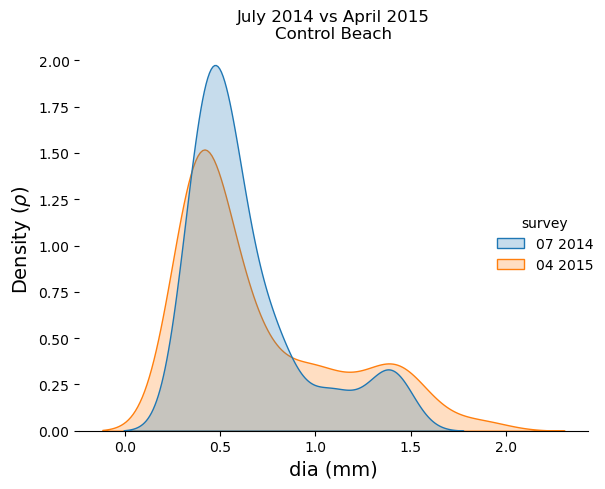

In [49]:
# FIGURE S1:
df = load_data(data_path, data_file_name)
# convert phi values to millimeters:
df['MOM_mm_mean'] = 2**((-1)*df['MOM_log_mean'])
df['FW_mm_mean'] = 2**((-1)*df['FW_phi_mean'])

X = df.loc[((df['survey'] == '07 2014') | (df['survey'] == '04 2015')) & (df['area'] == 'Replenished Beach')]

g = sns.displot(x='FW_mm_mean', hue='survey', data=X, kind='kde', common_norm=False, bw_method='silverman', bw_adjust=0.75, fill=True,)

plt.title('July 2014 vs April 2015\nControl Beach')
g.set_axis_labels('dia (mm)','Density ($\\rho$)', fontsize=14)

g.despine(left=True)
plt.tight_layout()

plt.savefig(plot_path+'Figure 5b Granulometry_2914-2015_KDE.png');

## FIGURE 5a

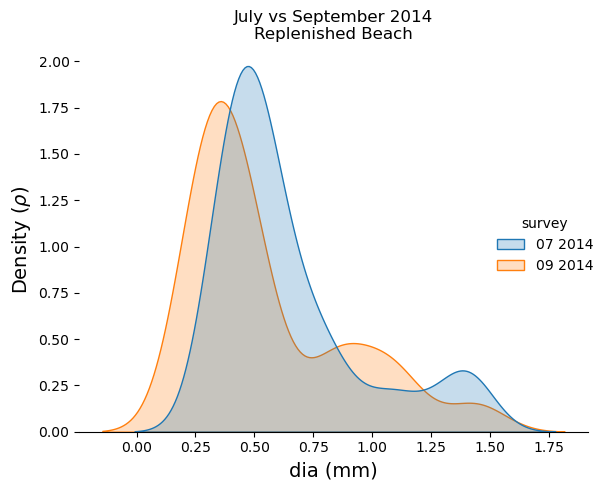

In [47]:
# FIGURE 5a:
df = load_data(data_path, data_file_name)
# convert phi values to millimeters:
df['MOM_mm_mean'] = 2**((-1)*df['MOM_log_mean'])
df['FW_mm_mean'] = 2**((-1)*df['FW_phi_mean'])

X = df.loc[((df['survey'] == '07 2014') | (df['survey'] == '09 2014')) & (df['area'] == 'Replenished Beach')]

g = sns.displot(x='FW_mm_mean', hue='survey', data=X, kind='kde', common_norm=False, bw_method='silverman', bw_adjust=0.75, fill=True,)

plt.title('July vs September 2014\nReplenished Beach')
g.set_axis_labels('dia (mm)','Density ($\\rho$)', fontsize=14)
g.despine(left=True)
plt.tight_layout()
plt.tight_layout()
plt.savefig(plot_path+'Figure 5a Granulometry_PrePost_KDE.png');

## FIGURE 5c

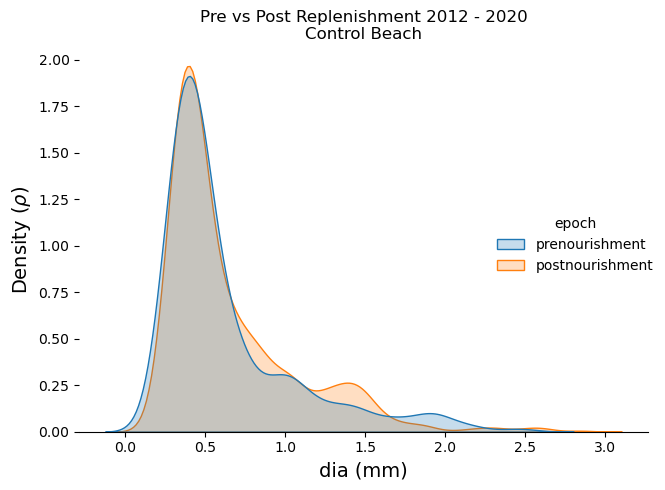

In [48]:
# FIGURE S3:
df = load_data(data_path, data_file_name)
# convert phi values to millimeters:
df['MOM_mm_mean'] = 2**((-1)*df['MOM_log_mean'])
df['FW_mm_mean'] = 2**((-1)*df['FW_phi_mean'])

X = df.loc[df['area'] == 'Control Beach']

g = sns.displot(x='FW_mm_mean', hue='epoch', data=X, kind='kde', common_norm=False, bw_method='silverman', bw_adjust=0.75, fill=True,)

plt.title('Pre vs Post Replenishment 2012 - 2020\nControl Beach')
g.set_axis_labels('dia (mm)','Density ($\\rho$)', fontsize=14)
g.despine(left=True)
plt.tight_layout()
plt.tight_layout()
plt.savefig(plot_path+'Figure 5c Granulometry_PrePost_KDE.png');

## FIGURE 5d

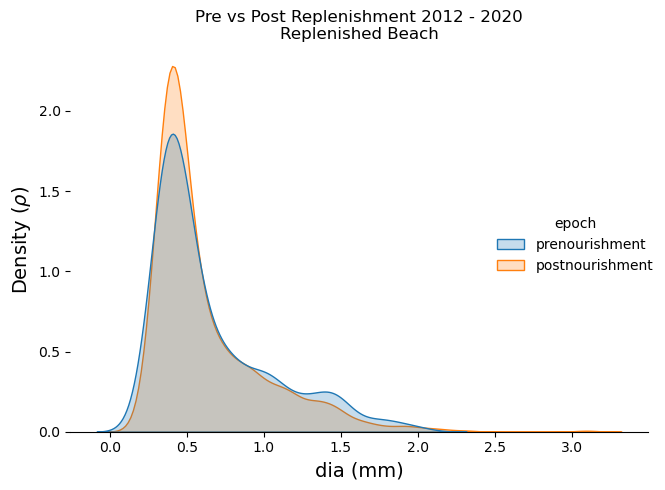

In [50]:
# FIGURE S4:
df = load_data(data_path, data_file_name)
# convert phi values to millimeters:
df['MOM_mm_mean'] = 2**((-1)*df['MOM_log_mean'])
df['FW_mm_mean'] = 2**((-1)*df['FW_phi_mean'])

X = df.loc[df['area'] == 'Replenished Beach']

g = sns.displot(x='FW_mm_mean', hue='epoch', data=X, kind='kde', common_norm=False, bw_method='silverman', bw_adjust=0.75, fill=True,)

plt.title('Pre vs Post Replenishment 2012 - 2020\nReplenished Beach')
g.set_axis_labels('dia (mm)','Density ($\\rho$)', fontsize=14)
g.despine(left=True)
plt.tight_layout()
plt.tight_layout()
plt.savefig(plot_path+'Figure 5d Granulometry_PrePost_KDE.png');

## FIGURE 4 

''

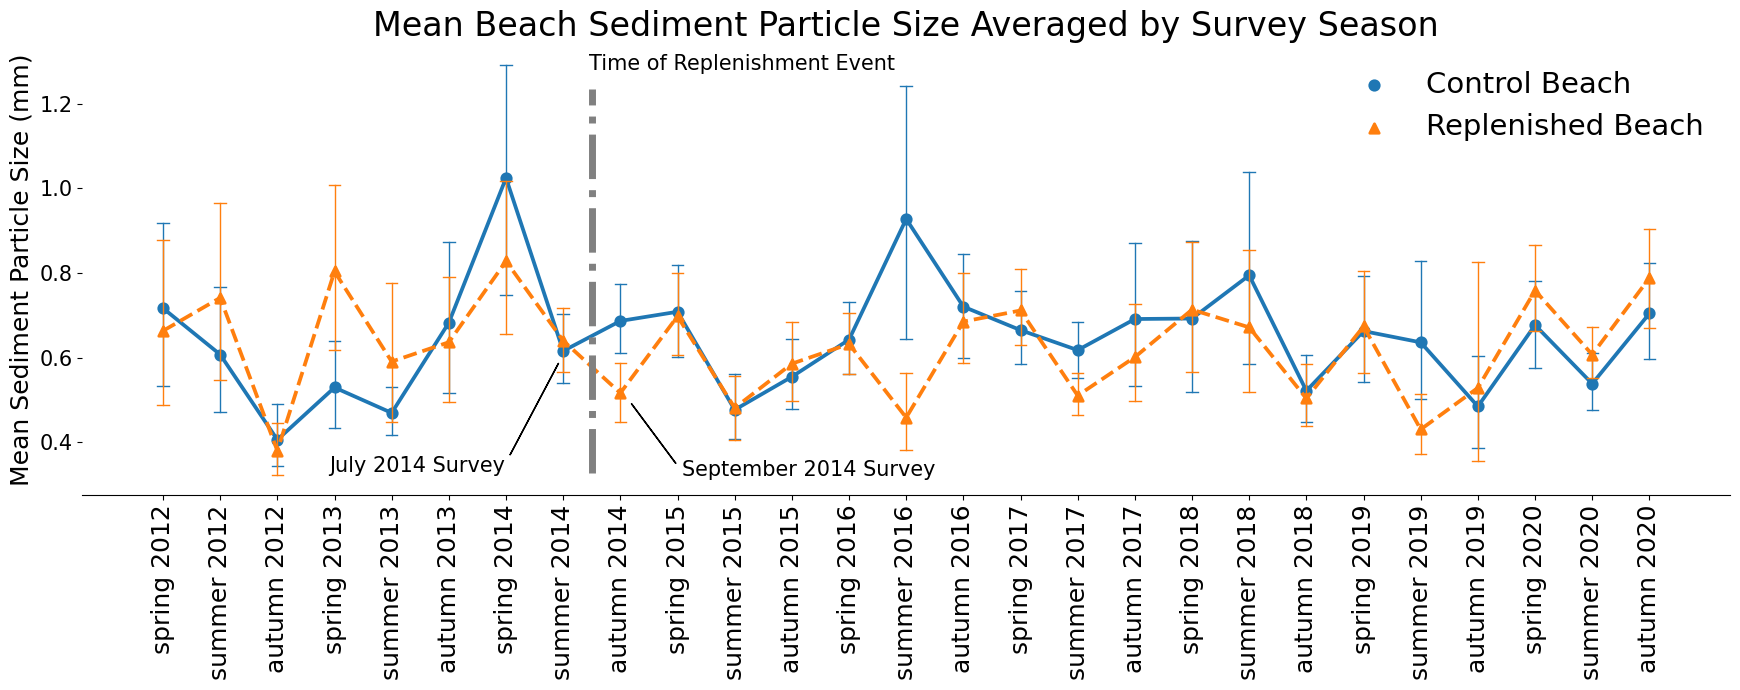

In [40]:
df = load_data(data_path, data_file_name)
df['MOM_mm_mean'] = 2**((-1)*df['MOM_log_mean'])
df['FW_mm_mean'] = 2**((-1)*df['FW_phi_mean'])

g = sns.catplot(x='survey_lbl', y='FW_mm_mean', hue='area', data=df,
    kind='point',
    markers=['o','^'], 
    linestyles=['solid','dashed'],
    height=7, aspect=2.5,
    ci=95, nboot=1000, errwidth=1.0, capsize=0.2,
    legend=False)
    
g.despine(left=True)
g.set_xticklabels(rotation=90, fontsize=18)
g.set_yticklabels(size=15)
g.set_axis_labels('', 'Mean Sediment Particle Size (mm)', size=18)

plt.axvline(7.5, 0.05, 0.90, linestyle='-.', linewidth=5.0, color='gray')
plt.text(7.45,1.28, 'Time of Replenishment Event', fontsize=15)

# draw survey labels and leaders:
plt.text(9.07,0.32, 'September 2014 Survey', fontsize=15)
plt.arrow(8.97, 0.35, -0.77, 0.14)
plt.text(2.9,0.33, 'July 2014 Survey', fontsize=15)
plt.arrow(6.07, 0.37, 0.842, 0.215)

plt.legend(loc='upper right', fontsize=21, frameon=False)
plt.title('Mean Beach Sediment Particle Size Averaged by Survey Season', size=24, loc='center')
plt.tight_layout()
plt.savefig(plot_path+'Figure 4 mean bch sand particle size_TSPlot_2012_20.png')
;
;

# Percent Fraction Time Series Plots

### The Plotting Engine: Shared instructions for generating particle size fraction time series plots!

Each of the time series plotting cells calls the engine to generate common portions of the plot graphic

In [ ]:
   facet_kws={"color":"darkred","alpha":0.3,"s":200}

In [12]:
def plotting_engine(X, pgrp):
    
    g = sns.catplot(x='survey_lbl', y='%'+pgrp, hue='area', data=X,
        kind='point',
        markers=['o','^'], 
        linestyles=['solid','dashed'],
        height=7, aspect=2.5,
        ci=None, nboot=1000, errwidth=1.5, capsize=0.2,
        legend=False)
    
    g.despine(left=True)
    g.set_xticklabels(rotation=90, fontsize=18)
    g.set_yticklabels(size=15)
    g.set_axis_labels('', '% Fraction of Total Sample', size=18)
    return(g)

## The Gravels:

''

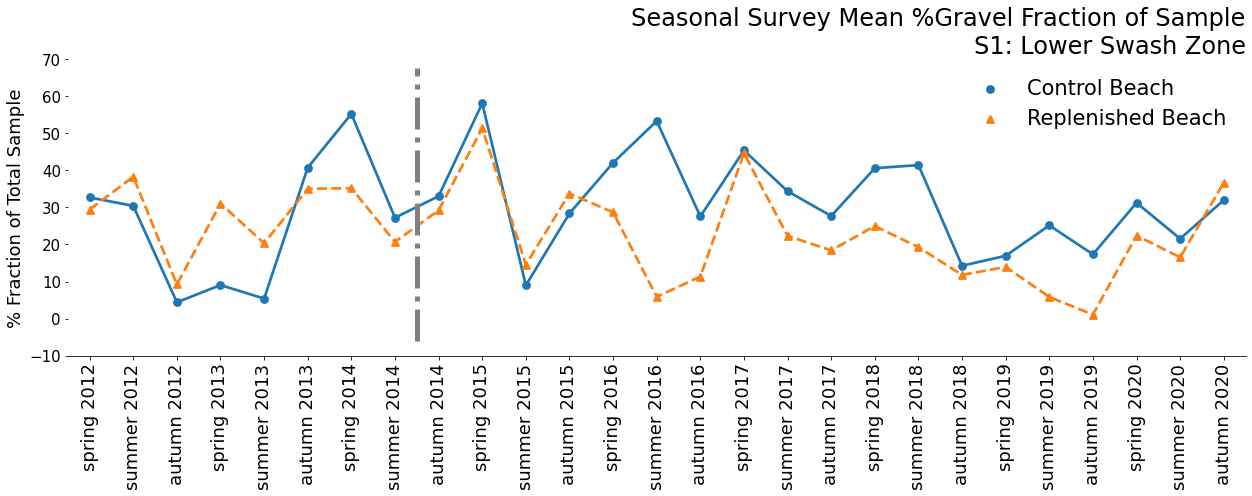

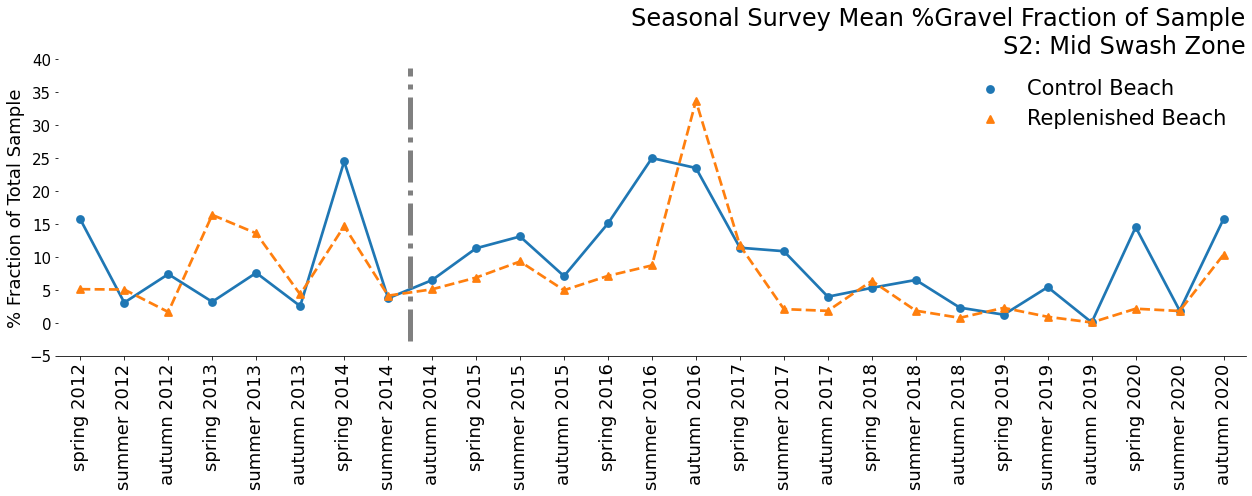

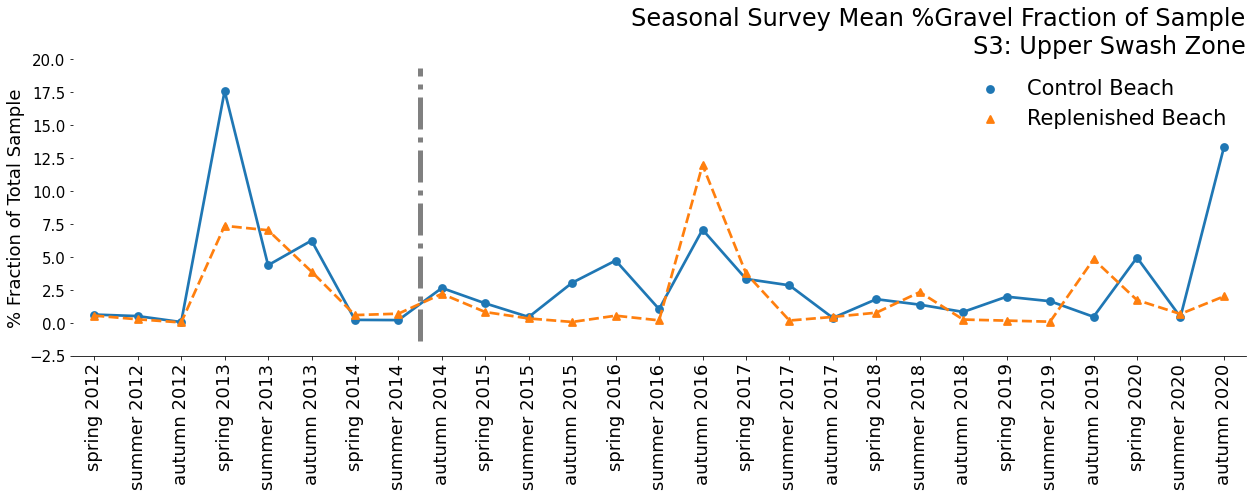

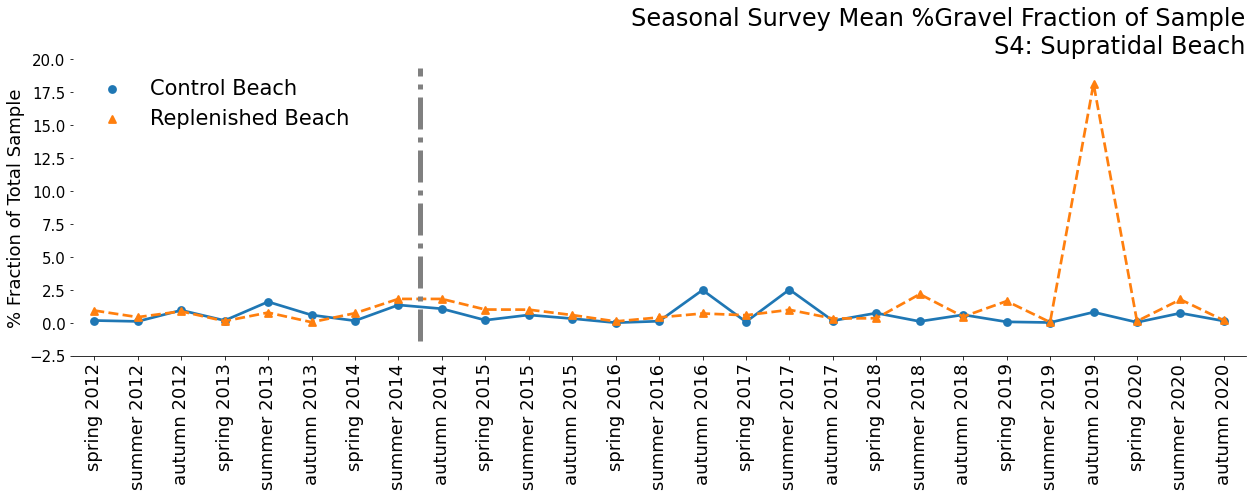

In [35]:
df = load_data(data_path, data_file_name)

beach_sample_sites = ['S1','S2','S3','S4']   # S45 is supratidal beach
beach_sample_site_lbls = ['S1: Lower Swash Zone','S2: Mid Swash Zone','S3: Upper Swash Zone','S4: Supratidal Beach']
event_label_txt_hts = [55.0,30.0,20.0,20.0]
legend_locations = ['upper right','upper right','upper right','upper left']
particle_group = 'gravels' 
particle_group_lbl = '%Gravel'

for beach_sample_site, beach_sample_site_lbl, event_label_txt_ht, legend_location in \
zip(beach_sample_sites,beach_sample_site_lbls, event_label_txt_hts, legend_locations):
    
    X = df.loc[df['sample'] == beach_sample_site ]

    g = plotting_engine(X, particle_group)
          
    plt.axvline(7.5, 0.05, 0.97, linestyle='-.', linewidth=5.0, color='gray')
    #plt.text(7.75,event_label_txt_ht, 'Time of Replenishment Event', fontsize=15)

    plt.legend(loc=legend_location, fontsize=21, frameon=False)
    plot_title = 'Seasonal Survey Mean ' + particle_group_lbl + ' Fraction of Sample\n' + beach_sample_site_lbl
    plt.title(plot_title, fontsize=24, loc='right')

    plt.tight_layout()

    plt.savefig(plot_path+'%gravel_'+beach_sample_site+'_TSPlot_2012_20.png')
;

## The Coarse Sands:

''

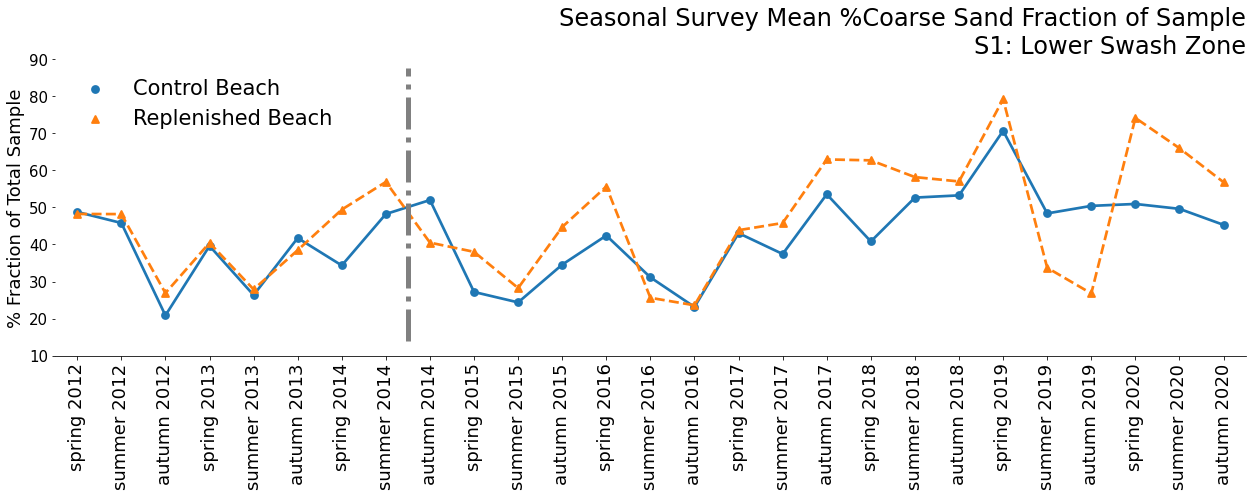

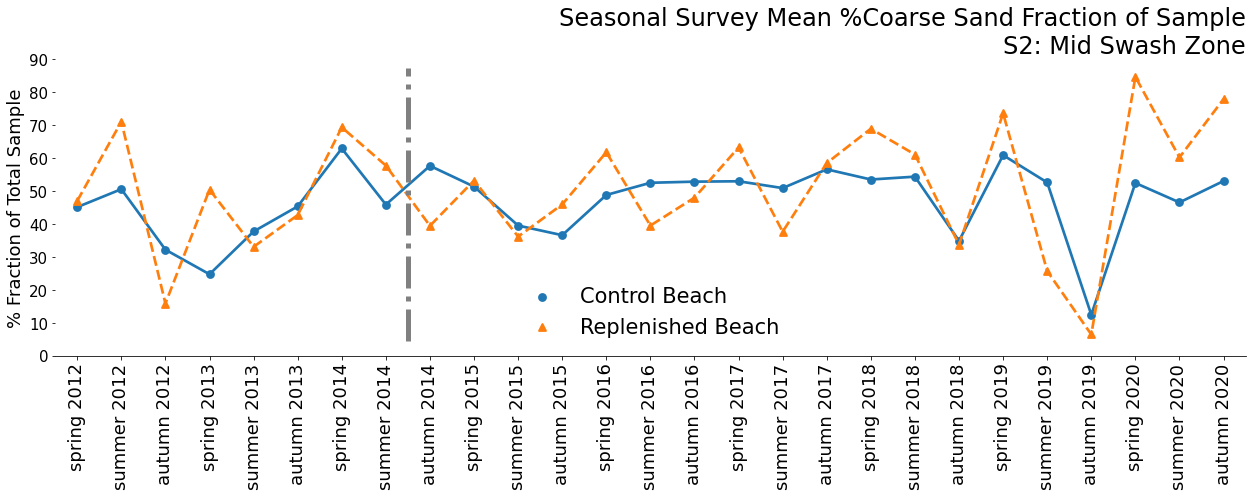

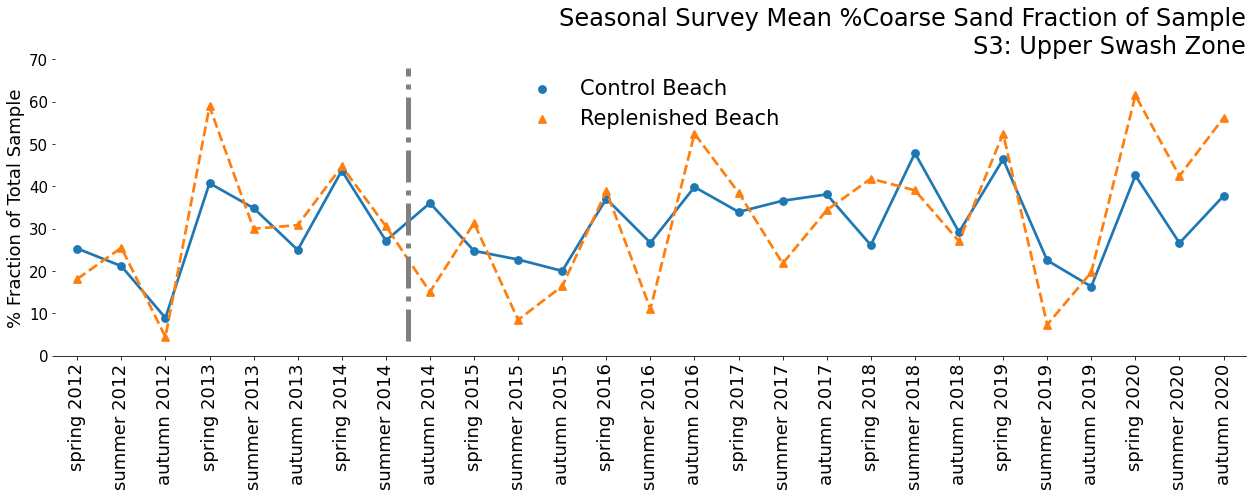

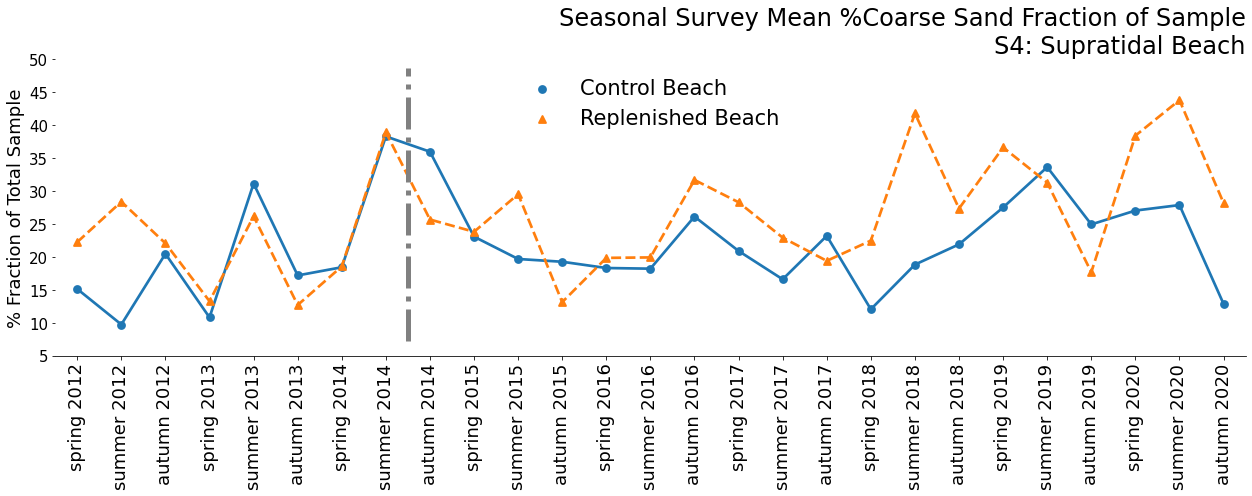

In [36]:
df = load_data(data_path, data_file_name)

beach_sample_sites = ['S1','S2','S3','S4']   # S4 is supratidal beach
beach_sample_site_lbls = ['S1: Lower Swash Zone','S2: Mid Swash Zone','S3: Upper Swash Zone','S4: Supratidal Beach']
event_label_txt_hts = [90.0,90.0,90.0,70.0]
legend_locations = ['upper left','lower center','upper center','upper center']
particle_group = 'c_sands' 
particle_group_lbl = '%Coarse Sand'

for beach_sample_site, beach_sample_site_lbl, event_label_txt_ht, legend_location in \
zip(beach_sample_sites,beach_sample_site_lbls, event_label_txt_hts, legend_locations):
    
    X = df.loc[df['sample'] == beach_sample_site ]

    #g = plotting_engine(X, particle_group)
    g = sns.catplot(x='survey_lbl', y='%'+particle_group, hue='area', data=X,
        kind='point',
        markers=['o','^'],
        linestyles=['solid','dashed'],
        height=7, aspect=2.5,
        ci=None, nboot=1000, errwidth=1.5, capsize=0.2,
        legend=False)
    
    g.despine(left=True)
    g.set_xticklabels(rotation=90, fontsize=18)
    g.set_yticklabels(size=15)
    g.set_axis_labels('', '% Fraction of Total Sample', size=18)
    plt.axvline(7.5, 0.05, 0.97, linestyle='-.', linewidth=5.0, color='gray')
   # plt.text(7.75,event_label_txt_ht, 'Time of Replenishment Event', fontsize=15)

    plt.legend(loc=legend_location, fontsize=21, frameon=False)
    plot_title = 'Seasonal Survey Mean ' + particle_group_lbl + ' Fraction of Sample\n' + beach_sample_site_lbl
    plt.title(plot_title, fontsize=24, loc='right')

    plt.tight_layout()

    plt.savefig(plot_path+'%coarse_sand_'+beach_sample_site+'_TSPlot_2012_20.png')
;

## The Medium Sands

''

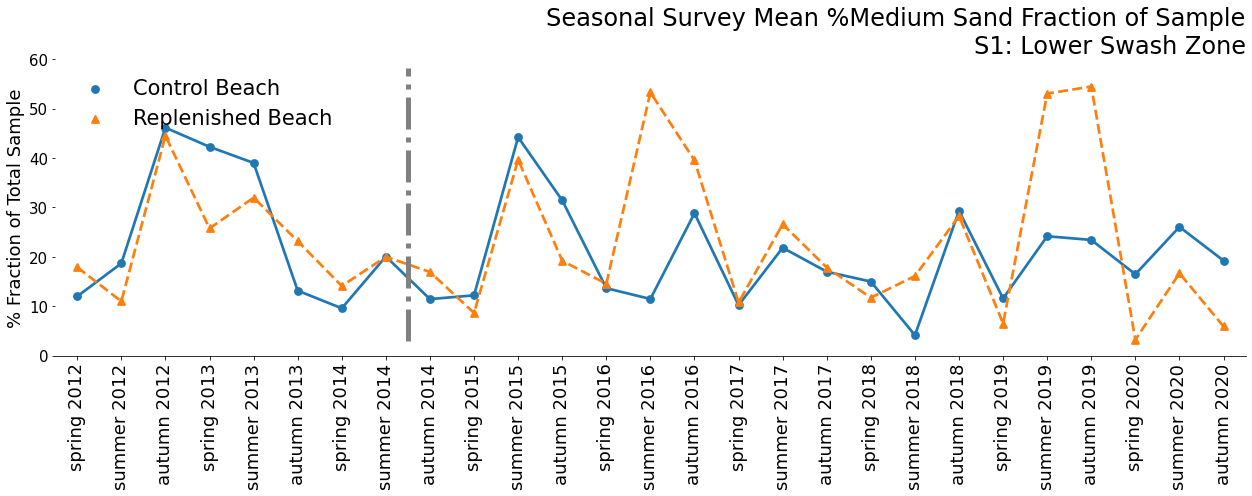

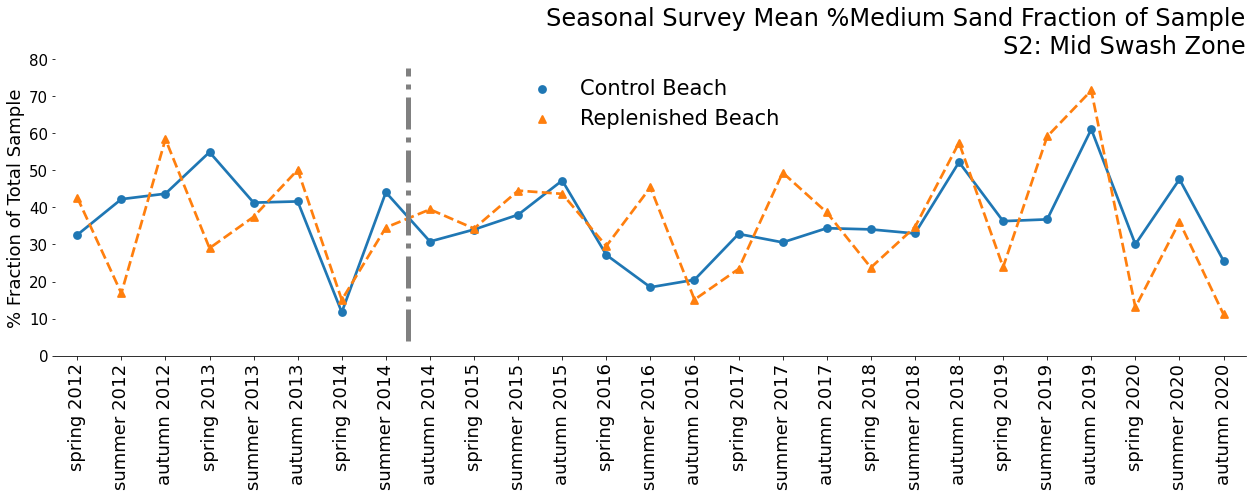

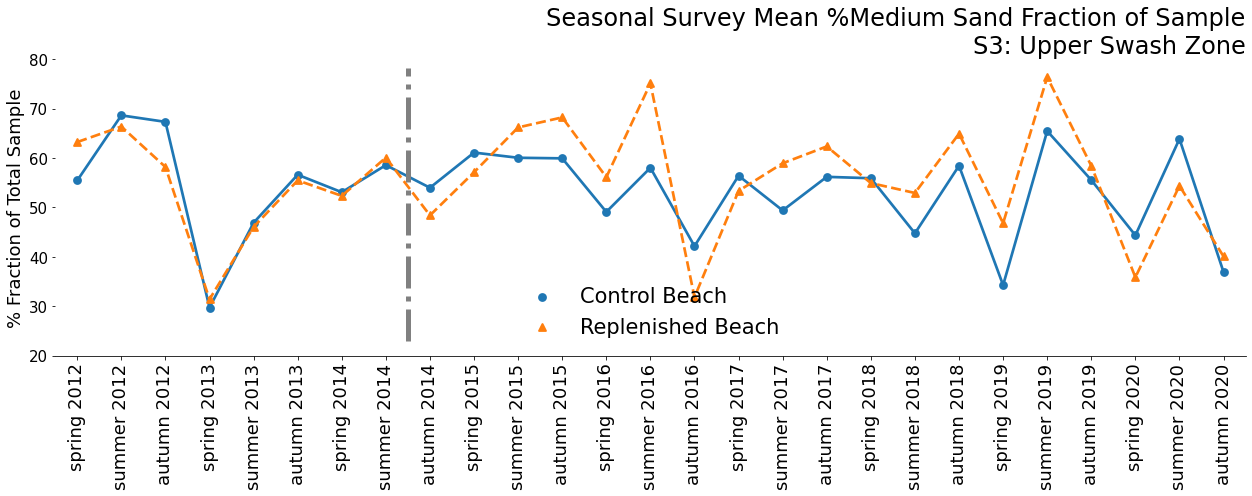

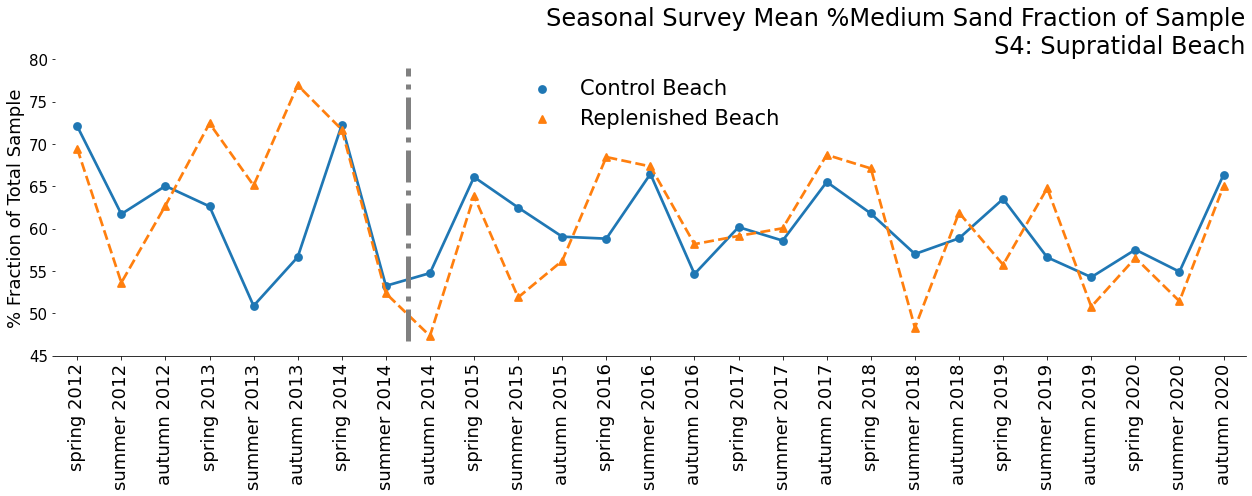

In [37]:
df = load_data(data_path, data_file_name)

beach_sample_sites = ['S1','S2','S3','S4']   # S4 is supratidal beach
beach_sample_site_lbls = ['S1: Lower Swash Zone','S2: Mid Swash Zone','S3: Upper Swash Zone','S4: Supratidal Beach']
event_label_txt_hts = [90.0,90.0,90.0,70.0]
legend_locations = ['upper left','upper center','lower center','upper center']
particle_group = 'm_sands' 
particle_group_lbl = '%Medium Sand'

for beach_sample_site, beach_sample_site_lbl, event_label_txt_ht, legend_location in \
zip(beach_sample_sites,beach_sample_site_lbls, event_label_txt_hts, legend_locations):
    
    X = df.loc[df['sample'] == beach_sample_site ]

    g = plotting_engine(X, particle_group)
    
    g.despine(left=True)
    g.set_xticklabels(rotation=90, fontsize=18)
    g.set_yticklabels(size=15)
    g.set_axis_labels('', '% Fraction of Total Sample', size=18)
    plt.axvline(7.5, 0.05, 0.97, linestyle='-.', linewidth=5.0, color='gray')
   # plt.text(7.75,event_label_txt_ht, 'Time of Replenishment Event', fontsize=15)

    plt.legend(loc=legend_location, fontsize=21, frameon=False)
    plot_title = 'Seasonal Survey Mean ' + particle_group_lbl + ' Fraction of Sample\n' + beach_sample_site_lbl
    plt.title(plot_title, fontsize=24, loc='right')

    plt.tight_layout()

    plt.savefig(plot_path+'%medium_sand_'+beach_sample_site+'_TSPlot_2012_20.png')
;

## The Fine Sands

''

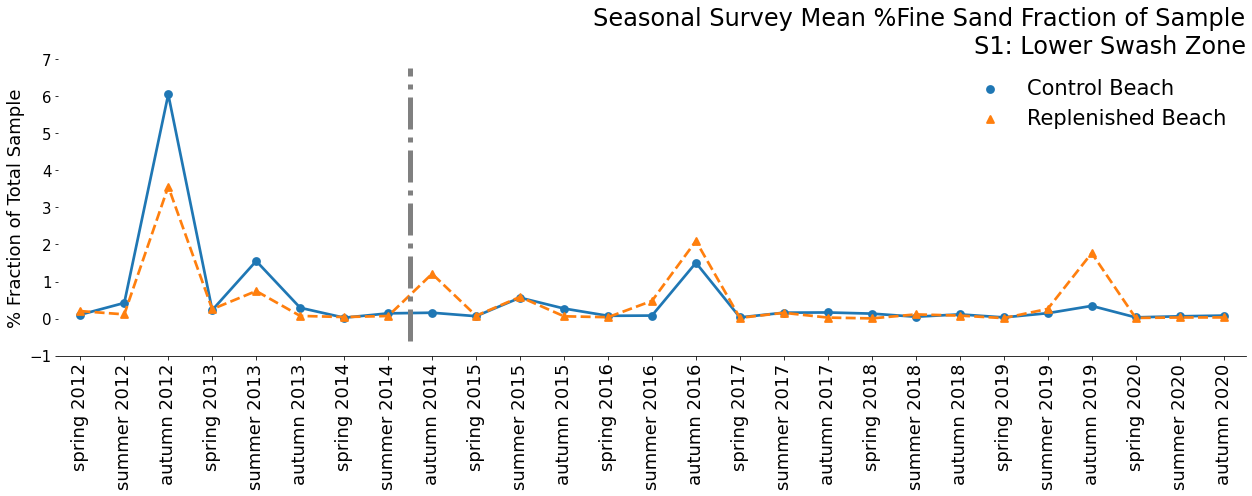

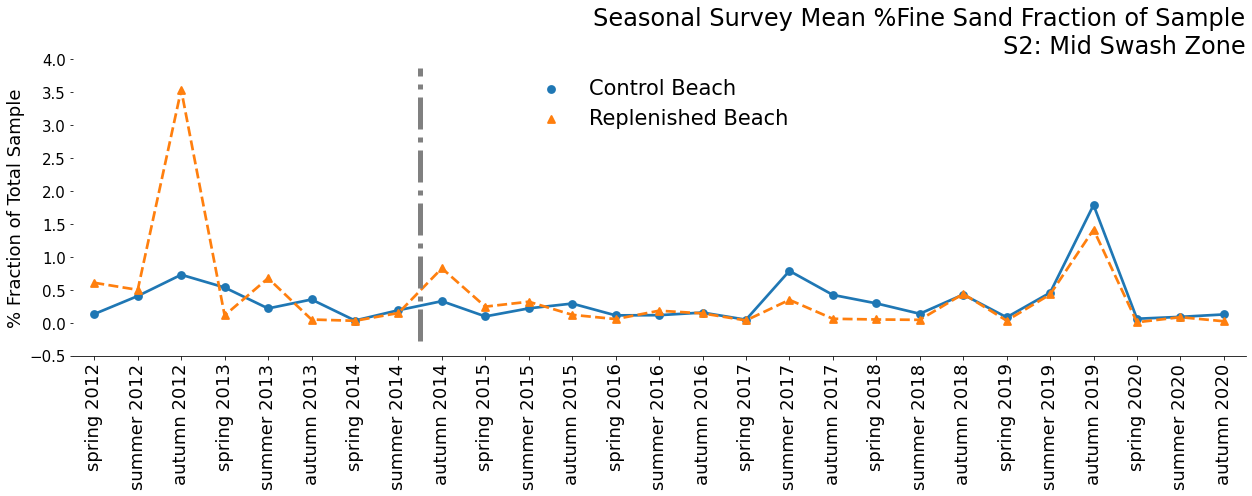

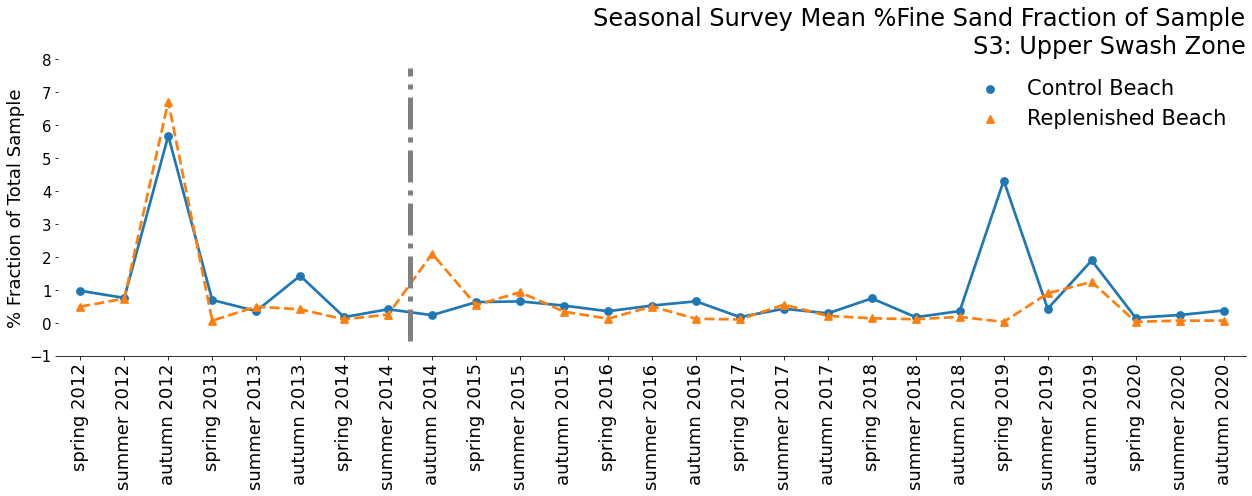

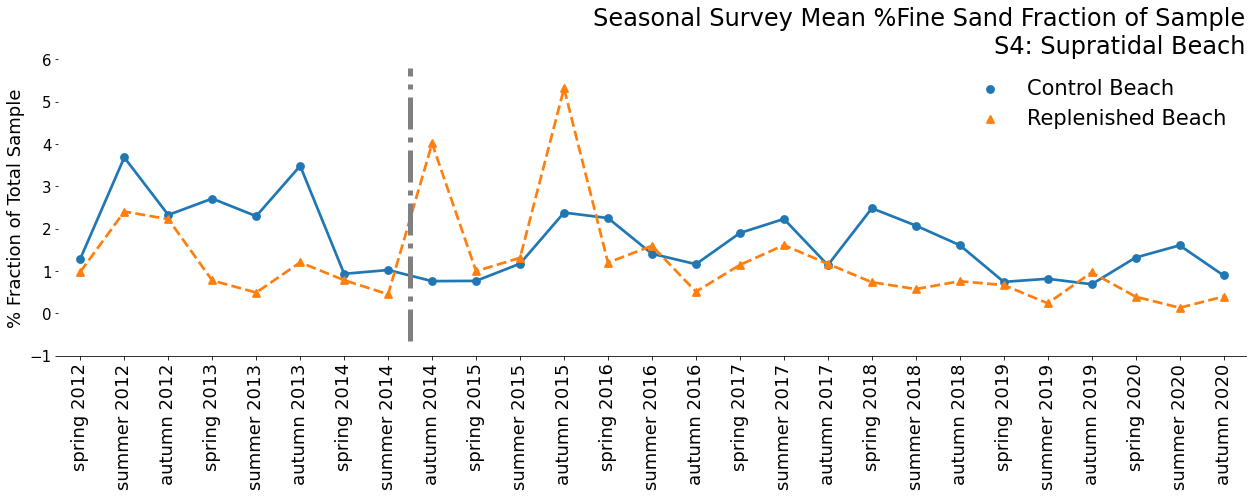

In [38]:
df = load_data(data_path, data_file_name)

beach_sample_sites = ['S1','S2','S3','S4']   # S4 is supratidal beach
beach_sample_site_lbls = ['S1: Lower Swash Zone','S2: Mid Swash Zone','S3: Upper Swash Zone','S4: Supratidal Beach']
event_label_txt_hts = [90.0,90.0,90.0,70.0]
legend_locations = ['upper right','upper center','upper right','upper right']
particle_group = 'f_sands' 
particle_group_lbl = '%Fine Sand'

for beach_sample_site, beach_sample_site_lbl, event_label_txt_ht, legend_location in \
zip(beach_sample_sites,beach_sample_site_lbls, event_label_txt_hts, legend_locations):
    
    X = df.loc[df['sample'] == beach_sample_site ]

    g = plotting_engine(X, particle_group)
    
    g.despine(left=True)
    g.set_xticklabels(rotation=90, fontsize=18)
    g.set_yticklabels(size=15)
    g.set_axis_labels('', '% Fraction of Total Sample', size=18)
    plt.axvline(7.5, 0.05, 0.97, linestyle='-.', linewidth=5.0, color='gray')
   # plt.text(7.75,event_label_txt_ht, 'Time of Replenishment Event', fontsize=15)

    plt.legend(loc=legend_location, fontsize=21, frameon=False)
    plot_title = 'Seasonal Survey Mean ' + particle_group_lbl + ' Fraction of Sample\n' + beach_sample_site_lbl
    plt.title(plot_title, fontsize=24, loc='right')

    plt.tight_layout()

    plt.savefig(plot_path+'%fine_sand_'+beach_sample_site+'_TSPlot_2012_20.png')
;

In [32]:
df

,transect_id,sample,sampling_date,season,CSI_transect,NCDOT_transect,origin,MOM_log_mean,MOM_log_sort,MOM_log_skew,...,area,epoch,%gravels,%c_sands,%m_sands,%f_sands,survey_lbl,zone,MOM_mm_mean,FW_mm_mean
28,apr2012_C11N,S1,2012-04-17,spring,C11,NT59,NCDOT,-0.81,0.73,0.35,...,Control Beach,prenourishment,48.849,49.850,1.201,0.001,spring 2012,Swash,1.753,2.099
29,apr2012_C11N,S2,2012-04-17,spring,C11,NT59,NCDOT,0.02,0.78,-0.33,...,Control Beach,prenourishment,11.912,81.982,5.806,0.102,spring 2012,Swash,0.986,0.993
30,apr2012_C11N,S3,2012-04-17,spring,C11,NT59,NCDOT,0.59,0.63,-0.44,...,Control Beach,prenourishment,1.208,79.658,18.832,0.053,spring 2012,Swash,0.664,0.651
31,apr2012_C11N,S4,2012-04-17,spring,C11,NT59,NCDOT,1.40,0.42,0.10,...,Control Beach,prenourishment,0.000,20.863,72.317,0.365,spring 2012,Supratidal Beach,0.379,0.384
32,apr2012_C09N,S1,2012-04-17,spring,C09,NT60,NCDOT,-0.11,0.72,0.08,...,Control Beach,prenourishment,8.133,87.651,3.815,0.004,spring 2012,Swash,1.079,1.072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3659,oct2020_T11C,S1,2020-10-15,autumn,T11,T11,CSI,-0.19,0.96,0.55,...,Replenished Beach,postnourishment,33.565,54.127,10.043,0.052,autumn 2020,Swash,1.141,1.474
3660,oct2020_T11C,S2,2020-10-15,autumn,T11,T11,CSI,0.51,0.76,0.03,...,Replenished Beach,postnourishment,2.659,74.051,20.679,0.040,autumn 2020,Swash,0.702,0.702
3661,oct2020_T11C,S3,2020-10-15,autumn,T11,T11,CSI,0.80,0.68,-0.60,...,Replenished Beach,postnourishment,1.499,56.061,40.810,0.016,autumn 2020,Swash,0.574,0.570
3662,oct2020_T11C,S4,2020-10-15,autumn,T11,T11,CSI,1.24,0.55,-0.48,...,Replenished Beach,postnourishment,0.085,30.020,64.849,0.102,autumn 2020,Supratidal Beach,0.423,0.420


# Tables:

## Table 1: Summary Particle Size Fraction Distributions for Native and Fill Sediments, Before and After Replenishment

In [20]:
### TABLE 1:  FROM THE BEGINNING TO THE END:

df = load_data(data_path, data_file_name)

X = pd.pivot_table(index=['area'], columns=['epoch'], values=['%gravels','%c_sands','%m_sands','%f_sands'], data=df, aggfunc=['mean'])
print('Table 1: Summary Particle Size Fraction Distributions for Native and Fill Sediments, Before and After Replenishment')
#X.to_latex(data_path+'Table 1.tex', index=True, float_format="%.3f")
X

Table 1: Summary Particle Size Fraction Distributions for Native and Fill Sediments, Before and After Replenishment


mean                                 \
                         %c_sands                       %f_sands   
epoch             postnourishment prenourishment postnourishment   
area                                                               
Control Beach              35.239         33.823           0.691   
Replenished Beach          39.727         38.079           0.659   

                                                                 \
                                        %gravels                  
epoch             prenourishment postnourishment prenourishment   
area                                                              
Control Beach              1.089          11.235          9.335   
Replenished Beach          0.767           8.632          9.072   

                                                  
                         %m_sands                 
epoch             postnourishment prenourishment  
area                                              
Control Beach              42.701         44.910  
Replenished Beach          42.898         44.057

In [21]:
### TABLE 1 addendum:  JUST BEFORE AND JUST AFTER:

df = load_data(data_path, data_file_name)

df = df.loc[((df['survey'] == '07 2014') | (df['survey'] == '09 2014')) & (df['epoch'] == 'postnourishment')].copy()
X = pd.pivot_table(index=['area'], columns=['epoch'], values=['%gravels','%c_sands','%m_sands','%f_sands'], data=df, aggfunc=['mean'])
print('Table 1 addendum: Summary Particle Size Fraction Distributions for Native and Fill Sediments, Just Before and After')
X

Table 1 addendum: Summary Particle Size Fraction Distributions for Native and Fill Sediments, Just Before and After


mean                                  \
                         %c_sands        %f_sands        %gravels   
epoch             postnourishment postnourishment postnourishment   
area                                                                
Control Beach              48.799           0.346          11.904   
Replenished Beach          33.383           1.756          10.188   

                                   
                         %m_sands  
epoch             postnourishment  
area                               
Control Beach              34.842  
Replenished Beach          37.956

## Table 2: native (baseline) and fill sand summary statistics

In [22]:
df = load_data(data_path, data_file_name)

X = pd.pivot_table(index=['area'], columns=['epoch'], values=['FW_mm_mean'], data=df, aggfunc=['mean','median','std'])
print('Table 2: Summary Statistics for Native and Fill Sediments, Before and After Replenishment')
X.to_latex(data_path+'Table 2.tex', index=True, float_format="%.3f")
X

Table 2: Summary Statistics for Native and Fill Sediments, Before and After Replenishment


mean                         median  \
                       FW_mm_mean                     FW_mm_mean   
epoch             postnourishment prenourishment postnourishment   
area                                                               
Control Beach               0.653          0.628           0.483   
Replenished Beach           0.627          0.656           0.476   

                                             std                 
                                      FW_mm_mean                 
epoch             prenourishment postnourishment prenourishment  
area                                                             
Control Beach              0.452           0.418          0.426  
Replenished Beach          0.485           0.368          0.387

In [23]:
### TABLE 2 addendum:  JUST BEFORE AND JUST AFTER:

df = load_data(data_path, data_file_name)

df = df.loc[((df['survey'] == '07 2014') | (df['survey'] == '09 2014')) & (df['epoch'] == 'postnourishment')].copy()
X = pd.pivot_table(index=['area'], columns=['epoch'], values=['FW_mm_mean'], data=df, aggfunc=['mean','median','std'])
print('Table 2 addendum: Summary Particle Size Fraction Distributions for Native and Fill Sediments, Just Before and After')
X

Table 2 addendum: Summary Particle Size Fraction Distributions for Native and Fill Sediments, Just Before and After


,mean,median,std
,FW_mm_mean,FW_mm_mean,FW_mm_mean
epoch,postnourishment,postnourishment,postnourishment
area,,,
Control Beach,0.718,0.557,0.374
Replenished Beach,0.552,0.425,0.332


## Table 3: Mean Sediment Particle Sizes Partitioned by Beach Sampling Location

S1=Lower Swash
S2 = Middle Swash
S3 = Upper Swash
S4 = Dune Toe

In [24]:
df = load_data(data_path, data_file_name)

X = pd.pivot_table(df, values=['FW_mm_mean'], index=['area','epoch'], columns=['sample'], aggfunc='mean', sort=True).T
print('Table 3: 3-Number-Summary Statistics (mean, median, stdev) for Native and Fill Sediments, Before and After Replenishment')
X.to_latex(data_path+'Table 3.tex', index=True, float_format="%.3f")
X

Table 3: 3-Number-Summary Statistics (mean, median, stdev) for Native and Fill Sediments, Before and After Replenishment


area                Control Beach                Replenished Beach  \
epoch             postnourishment prenourishment   postnourishment   
           sample                                                    
FW_mm_mean S1               1.154          1.041             1.053   
           S2               0.709          0.631             0.668   
           S3               0.475          0.454             0.444   
           S4               0.376          0.388             0.412   
           S5               0.368            NaN             0.463   

area                              
epoch             prenourishment  
           sample                 
FW_mm_mean S1              1.083  
           S2              0.677  
           S3              0.450  
           S4              0.413  
           S5                NaN

In [34]:
### TABLE 3 addendum:  JUST BEFORE AND JUST AFTER:

df = load_data(data_path, data_file_name)

df = df.loc[((df['survey'] == '07 2014') | (df['survey'] == '09 2014')) & (df['epoch'] == 'postnourishment')].copy()
X = pd.pivot_table(df, values=['FW_mm_mean'], index=['area','epoch'], columns=['sample'], aggfunc='mean', sort=True).T
print('Table 3 addendum: Summary Statistics for Native and Fill Sediments, Before and After Replenishment')
X

Table 3 addendum: Summary Statistics for Native and Fill Sediments, Before and After Replenishment


area                Control Beach Replenished Beach
epoch             postnourishment   postnourishment
           sample                                  
FW_mm_mean S1               1.311             1.026
           S2               0.658             0.513
           S3               0.457             0.281
           S4               0.446             0.390

## Table 4: Summary Particle Size Fraction Distributions for Native and Fill Sediments

In [29]:
df = load_data(data_path, data_file_name)

X = pd.pivot_table(df, values=['%gravels','%c_sands','%m_sands','%f_sands'], index=['area','epoch'], columns=['sample'], aggfunc='mean', sort=True).T
print('Table 4: Summary Particle Size Fraction (Mean particle diameter) Distributions for Native and Fill Sediments')
X.to_latex(data_path+'Table 4.tex', index=True, float_format="%.3f")
X

Table 4: Summary Particle Size Fraction (Mean particle diameter) Distributions for Native and Fill Sediments


area              Control Beach                Replenished Beach  \
epoch           postnourishment prenourishment   postnourishment   
         sample                                                    
%c_sands S1              41.615         40.083            47.436   
         S2              49.225         43.566            52.906   
         S3              32.568         28.120            33.660   
         S4              22.701         23.523            26.783   
         S5              20.780            NaN            35.097   
%f_sands S1               0.245          0.924             0.400   
         S2               0.279          0.299             0.234   
         S3               0.558          1.139             0.445   
         S4               1.495          1.994             1.509   
         S5               1.226            NaN             0.784   
%gravels S1              33.874         25.940            26.058   
         S2              10.612          7.566             7.681   
         S3               3.356          3.066             2.141   
         S4               0.662          0.766             1.248   
         S5               1.162            NaN             2.222   
%m_sands S1              19.249         24.174            20.358   
         S2              33.962         39.964            33.779   
         S3              52.689         55.288            53.724   
         S4              59.505         60.212            58.927   
         S5              57.992            NaN            54.749   

area                            
epoch           prenourishment  
         sample                 
%c_sands S1             45.253  
         S2             50.390  
         S3             30.416  
         S4             26.258  
         S5                NaN  
%f_sands S1              0.512  
         S2              0.586  
         S3              0.960  
         S4              1.009  
         S5                NaN  
%gravels S1             25.964  
         S2              7.236  
         S3              2.143  
         S4              0.947  
         S5                NaN  
%m_sands S1             22.786  
         S2             35.322  
         S3             55.426  
         S4             62.693  
         S5                NaN

In [30]:
### TABLE 4 addendum:  JUST BEFORE AND JUST AFTER:

df = load_data(data_path, data_file_name)

df = df.loc[((df['survey'] == '07 2014') | (df['survey'] == '09 2014')) & (df['epoch'] == 'postnourishment')].copy()
X = pd.pivot_table(df, values=['%gravels','%c_sands','%m_sands','%f_sands'], index=['area','epoch'], columns=['sample'], aggfunc='mean', sort=True).T
print('Table 4 addendum: Summary Statistics for Native and Fill Sediments, Before and After Replenishment')
X

Table 4 addendum: Summary Statistics for Native and Fill Sediments, Before and After Replenishment


area              Control Beach Replenished Beach
epoch           postnourishment   postnourishment
         sample                                  
%c_sands S1              56.133            51.382
         S2              65.404            43.331
         S3              37.850             7.866
         S4              35.807            30.953
%f_sands S1               0.030             0.160
         S2               0.301             0.452
         S3               0.168             2.423
         S4               0.886             3.988
%gravels S1              41.977            34.863
         S2               4.297             4.006
         S3               0.706             0.300
         S4               0.635             1.584
%m_sands S1               1.788            11.458
         S2              28.061            41.843
         S3              55.203            53.774
         S4              54.317            44.748

## Table 5: Dark Mineral Particles

## "Dark" Minerals:

We here consider the dark minerals as a surrogate for the heavy mineral constitutent of the sands found on the beach. By heavy minerals we refer to those mineral species whose densities are in excess of quartz (>2.65 gm/cc). Such species include, but are not limited to: ilmenite, magnitite, amphibole/pyroxene, garnet, hornblende, and tormaline. These as a group occur typically in very samll relative quantitites on the beaches of the Outer Banks, but theire presence, and in the quantities that they occur, they nevertheless contribute to the substrate properties in ways that impact the resident fauna.

The minerals are referred to as "dark" here, as opposed to heavy (in association with their relative densities) has to do with the methods used to measure quantity. In lieu of a microscopic assay we use a photomicrographic technique that partitions the dark opaque particles from those light in color and generally translucent in light tranmission. The former are classified as "dark" a prxy for heavy minerals. The lighter tranlucent fraction are quartz sands. 

In [31]:
# RUN THIS SCRIPT BEFORE GENERATING TABLE 5

df_ = pd.read_csv(data_path+'heavy_minerals.csv')
df_.query("transect_I != ['T12','T13','T14','T15','T16']", inplace=True)   # not using these 5 transects

df_['zone'] = 'Upper Beach'
df_.loc[(df_['sample_ID'] == 'S1') | (df_['sample_ID'] == 'S2') | (df_['sample_ID'] == 'S3'), 'zone'] = 'Swash Zone'

#df_ = df_.loc[(df_['year'] == 2014) & (df_['season'] == 'summer') & (df_['area'] == 'Control')].copy()

# add a date field that increments chronolically so that we can space the x-axis year ticks in accord with their chrono spacing
df_['Survey_Datetime'] = pd.to_datetime(df_['sample_dat'], format='%Y/%m/%d')
df_['DateJ'] = pd.DatetimeIndex(df_['Survey_Datetime']).floor('d').to_julian_date()+0.5

dfg = df_.groupby(['year','area','season','sample_ID','light_dark']).agg({'Survey_Datetime':'first','count':'sum','zone':'first','DateJ':'first'}).reset_index()

#['count'].sum().reset_index()  # group dataframe content on y, a, s, id, ld
c = dfg.filter(items=['count'], axis=1)                                                            # extract count column from dfg
r = (c.shift(1) / c )                                                                              # compute ratio of current and next lines in c
dfg.update(r)                                                                                      # restore ratio results to dfg count column

dfg.query("count < 1.0", inplace=True)                            # drop recs whose count is > 1 - these are percent light particles
dfg.drop(['light_dark'], axis=1, inplace=True)                    # drop the no longer meeded light_dark column
dfg['pct_dark']=dfg['count']*100                                  # create new column that is the percentage of the count ratio of dark particles

# sort on Survey Datetime
dfg.sort_values(by='Survey_Datetime', inplace=True)

dfg['DateJ'] = dfg['DateJ'].astype(np.int64)

In [32]:
dfg.loc[dfg['Survey_Datetime'] <= '2014-07-31', 'epoch'] = 'pre'
dfg.loc[dfg['Survey_Datetime'] >= '2014-09-01', 'epoch'] = 'post'
X = pd.pivot_table(dfg, values=['pct_dark'], index=['area','epoch'], columns=['sample_ID'], aggfunc='median', sort=True).T
print('Table 5: Percent "Dark Mineral" Content Pre and Post-Replenishment - Overall')
X.to_latex(data_path+'Table 5.tex', index=True, float_format="%.2f")
X

Table 5: Percent "Dark Mineral" Content Pre and Post-Replenishment - Overall


area               Control        Treatment       
epoch                 post    pre      post    pre
         sample_ID                                
pct_dark S1          3.961  3.122     2.827  2.997
         S2          2.880  2.718     2.803  2.296
         S3          3.156  2.690     2.910  2.733
         S4          5.091  5.122     3.978  4.076
         S5          4.389    NaN     3.635    NaN

In [33]:
### TABLE 5 addendum:  JUST BEFORE AND JUST AFTER:

dfg.loc[dfg['Survey_Datetime'] <= '2014-07-31', 'epoch'] = 'pre'
dfg.loc[dfg['Survey_Datetime'] >= '2014-09-01', 'epoch'] = 'post'
dfg = dfg.loc[(dfg['Survey_Datetime'] == '2014-07-14') | (dfg['Survey_Datetime'] == '2014-09-29') & (dfg['epoch'] == 'post')].copy()

X = pd.pivot_table(dfg, values=['pct_dark'], index=['area','epoch'], columns=['sample_ID'], aggfunc='median', sort=True).T
print('Table 5 addendum: Percent "Dark Mineral" Content Pre and Post-Replenishment - Overall')
X

Table 5 addendum: Percent "Dark Mineral" Content Pre and Post-Replenishment - Overall


area               Control        Treatment       
epoch                 post    pre      post    pre
         sample_ID                                
pct_dark S1          5.276  3.122     3.752  2.997
         S2          3.426  2.718     2.699  2.296
         S3          2.969  2.690     3.287  2.733
         S4          5.014  5.122     2.323  4.076

## Supplementary Table 2: Dark Mineral Content Averaged by Survey

In [51]:
#drop some columns before generating the table:
dfg.drop(['DateJ','count'], axis=1, inplace=True)
dfg.to_latex(data_path+'Supplementary Table 2.tex', index=True, float_format="%.3f")

/var/folders/61/5nyq9bfn6c113jdtjxq0_36r0000gn/T/ipykernel_25493/1548104695.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfg.to_latex(data_path+'Supplementary Table 2.tex', index=True, float_format="%.3f")


## Extracting individual bits from the dark minerals data...

In [ ]:
dfg.loc[dfg['area'] == 'Control'].max()

''

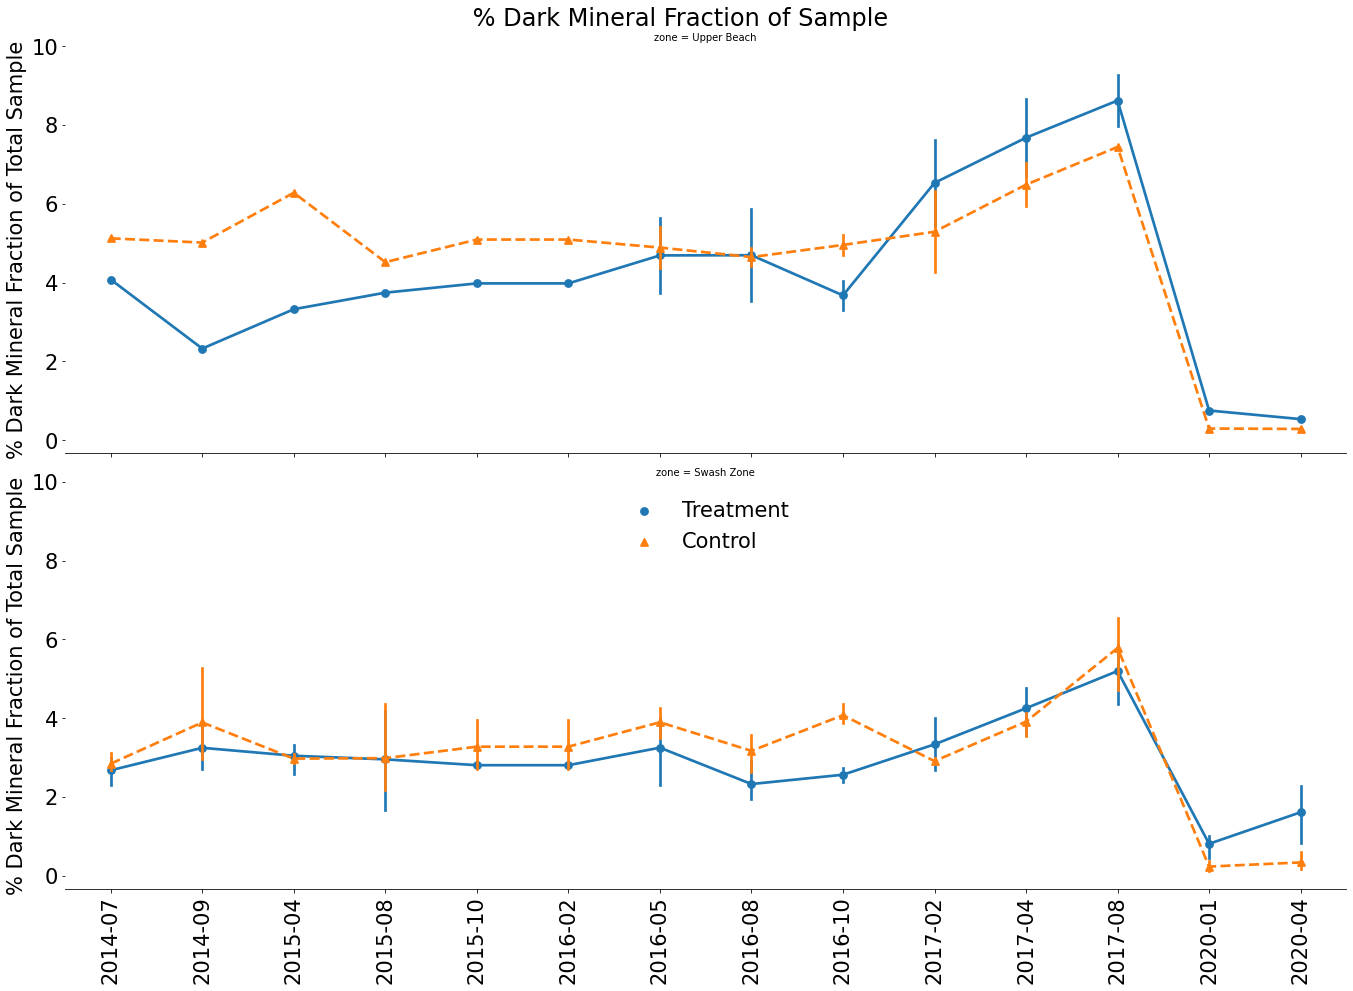

In [450]:


g = sns.catplot(x='DateJ', y='pct_dark', hue='area', row='zone', data=dfg,
                kind='point',
                markers=['o','^'],
                linestyles=['solid','dashed'],
                height=7, aspect=2.7,
                legend=False)

g.set_axis_labels('', '% Dark Mineral Fraction of Total Sample', size=21)
g.despine(left=True)


#g.set(xlim=(dfg.DateJ.min()-100,dfg.DateJ.max()+100))
#g.set(xticks=[2456853, 2456930, 2457141, 2457239, 2457316, 2457436, 2457519, 2457610, 2457675, 2457804, 2457871, 2457970, 2458857, 2458968])
g.set_xticklabels(['2014-07','2014-09','2015-04','2015-08','2015-10','2016-02','2016-05','2016-08','2016-10','2017-02','2017-04','2017-08','2020-01','2020-04'], rotation=90, fontsize=21)
      
g.set(yticks=[0,2,4,6,8,10])
g.set_yticklabels(['0','2','4','6','8','10'], size = 21)
#g.set_xticklabels(rotation=90, fontsize=21)
    
#plt.axvline(2456853, 0.1, 10.0, linestyle='-.', linewidth=5.0, color='gray')
#plt.text(0.65,3.7, 'Time of Replenishment Event', fontsize=15)

plt.legend(loc='upper center', fontsize=21, frameon=False)
plt.suptitle(' % Dark Mineral Fraction of Sample', fontsize=24)

plt.tight_layout()

#plt.savefig(plot_path+'%Dark_mineral_TimeSeriesPlot_2014_20.png')
;

In [ ]:
# END OF TABLES SECTION

''

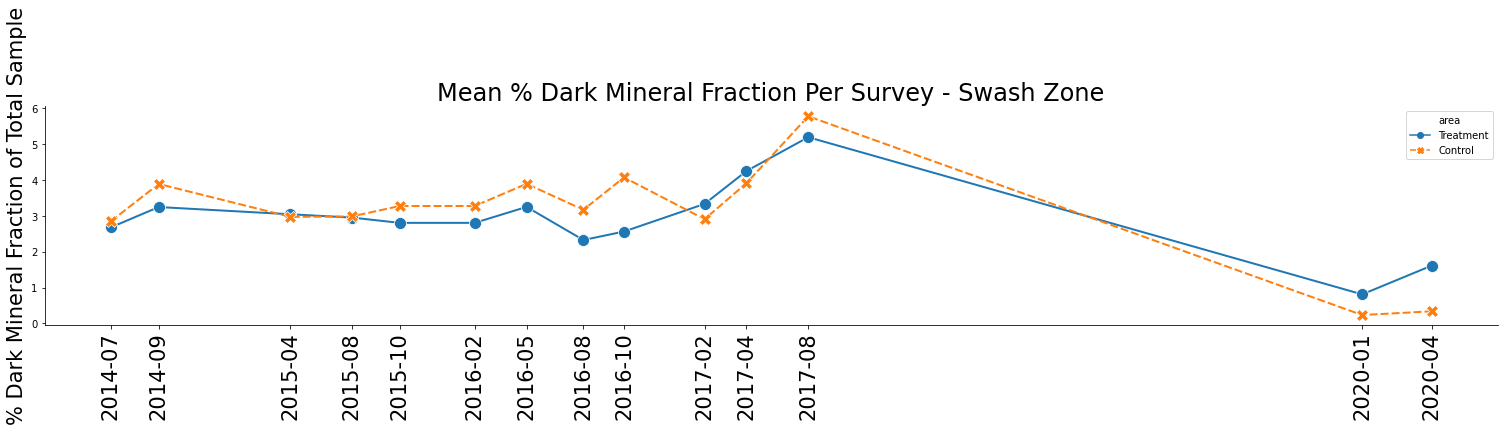

In [43]:
fig = plt.figure(figsize=(21,5))
ax01 = fig.add_subplot(1,1,1)

X = dfg.loc[dfg['zone'] == 'Swash Zone']

xtics=[2456853, 2456930, 2457141, 2457239, 2457316, 2457436, 2457519, 2457610, 2457675, 2457804, 2457871, 2457970, 2458857, 2458968]
xticlabels=['2014-07','2014-09','2015-04','2015-08','2015-10','2016-02','2016-05','2016-08','2016-10','2017-02','2017-04','2017-08','2020-01','2020-04']
      
#{'markers':['o','^'],'linestyles':['solid','dashed']}
sns.lineplot(x='DateJ',y='pct_dark', hue='area', data=X, ci=None, markers=True, style='area', linewidth=2, markersize=12, ax=ax01)
ax01.set_xlabel('')
ax01.set_ylabel('% Dark Mineral Fraction of Total Sample', size=21)

ax01.xaxis.set_major_locator(matplotlib.ticker.FixedLocator(xtics))
ax01.xaxis.set_major_formatter(matplotlib.ticker.FixedFormatter(xticlabels))
plt.xticks(rotation=90, fontsize=21)

sns.despine(right=True)

plt.title('Mean % Dark Mineral Fraction Per Survey - Swash Zone', fontsize=24)
plt.tight_layout()

;

''

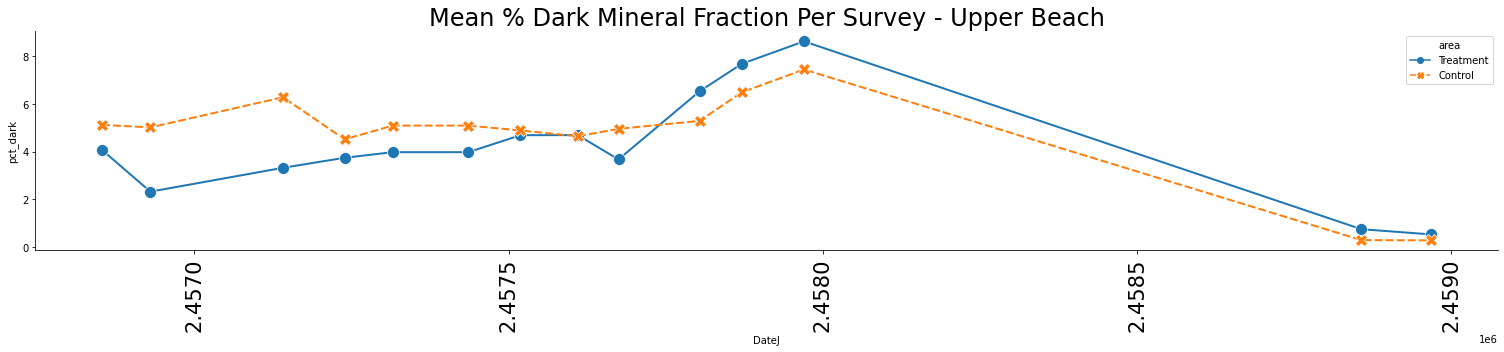

In [44]:
fig2 = plt.figure(figsize=(21,5))
ax02 = fig2.add_subplot(1,1,1)

X = dfg.loc[dfg['zone'] == 'Upper Beach']

xtics=[2456853, 2456930, 2457141, 2457239, 2457316, 2457436, 2457519, 2457610, 2457675, 2457804, 2457871, 2457970, 2458857, 2458968]
xticlabels=['2014-07','2014-09','2015-04','2015-08','2015-10','2016-02','2016-05','2016-08','2016-10','2017-02','2017-04','2017-08','2020-01','2020-04']
      
#{'markers':['o','^'],'linestyles':['solid','dashed']}
sns.lineplot(x='DateJ',y='pct_dark', hue='area', data=X, ci=None, markers=True, style='area', linewidth=2, markersize=12, ax=ax02)
ax01.set_xlabel('')
ax01.set_ylabel('% Dark Mineral Fraction of Total Sample', size=21)

ax01.xaxis.set_major_locator(matplotlib.ticker.FixedLocator(xtics))
ax01.xaxis.set_major_formatter(matplotlib.ticker.FixedFormatter(xticlabels))
plt.xticks(rotation=90, fontsize=21)

sns.despine(right=True)

plt.title('Mean % Dark Mineral Fraction Per Survey - Upper Beach', fontsize=24)
plt.tight_layout()

;

#### Sorting - Immediate before and after replenishment Pt 3:

Working Figure Caption: Kernel Density Estimates of beach sand grain size sorting (standard deviation) comparing the sample standard deviations from surveys taken immediately before replenishment (July 204) and in the immediate afternath (September 2014) for the swash and upper beach zones in both the control and treatment (impacted) transect sites. Grain size statistics determined by maechanical sieving using the inclusive graphic percentile method (Folk and Ward 1957).

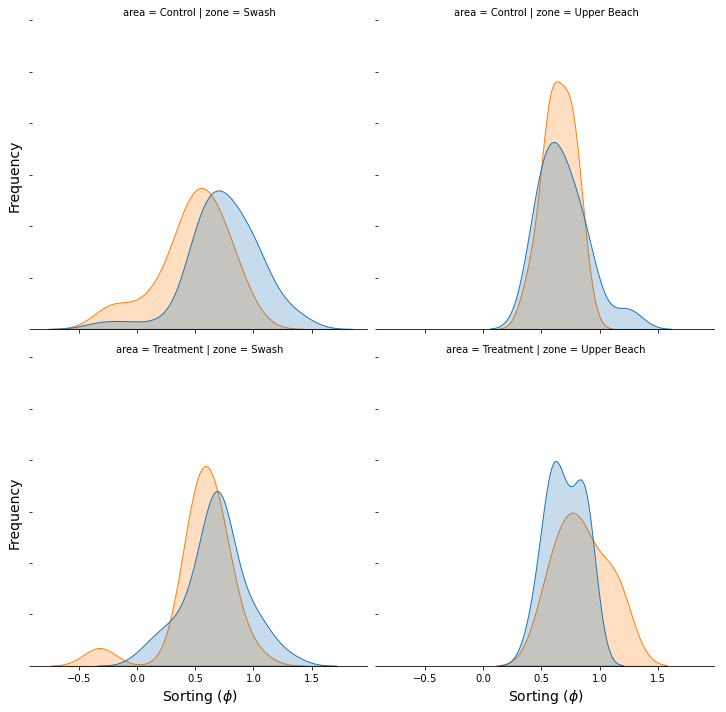

In [15]:
X = df.loc[((df['survey'] == '07 2014') | (df['survey'] == '09 2014'))]

g = sns.displot(x='FW_phi_sort', hue='survey', row='area', col='zone', data=X, kind='kde', \
                common_norm=False, bw_method='silverman', bw_adjust=1.0, fill=True, rug=False, legend=False)
g.set_axis_labels('Sorting ($\phi$)', 'Frequency', size=14)
g.set_yticklabels(fontsize=14)
g.add_legend()
#g.set_title('Sand Grain Sorting')

g.despine(left=True)
plt.tight_layout();

### CDF Plots - Check on Inclusive Graphic Percentile (IGP) Assumptions

The bi-modality displayed in the IGP statistics plots above should present a caution to the user as this condition might suggest that the important assumption that the data are  unimodal and log-normally distributed might be violated. The plots below suggest that this voilation concern is a reasonable one, as if the assumptions were met exactly the lines drawn would be straight (i.e., no curvature along the path)". Here, this is clearly not the case, however, the departure isn't too bad and so we may feel reasonably confident that our density estimators are pretty good predictors of the distribution function for these data.

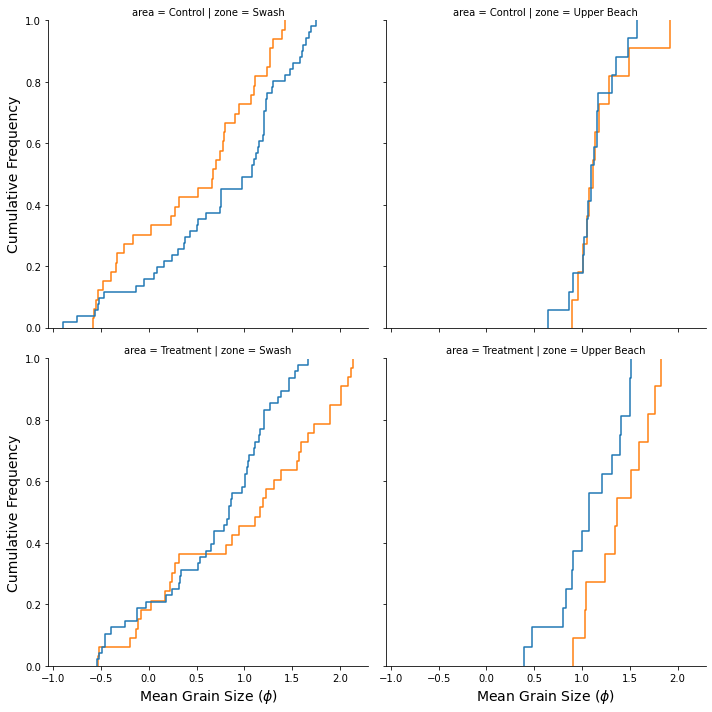

In [16]:
g = sns.displot(x='FW_phi_mean', hue='survey', row='area', col='zone', data=X, kind='ecdf', rug=False, legend=False)
g.set_axis_labels('Mean Grain Size ($\phi$)', 'Cumulative Frequency', fontsize=14)

plt.tight_layout();

In [17]:
X.survey.unique()


array(['07 2014', '09 2014'], dtype=object)

### Immediate changes in mean grain-size distributions

''

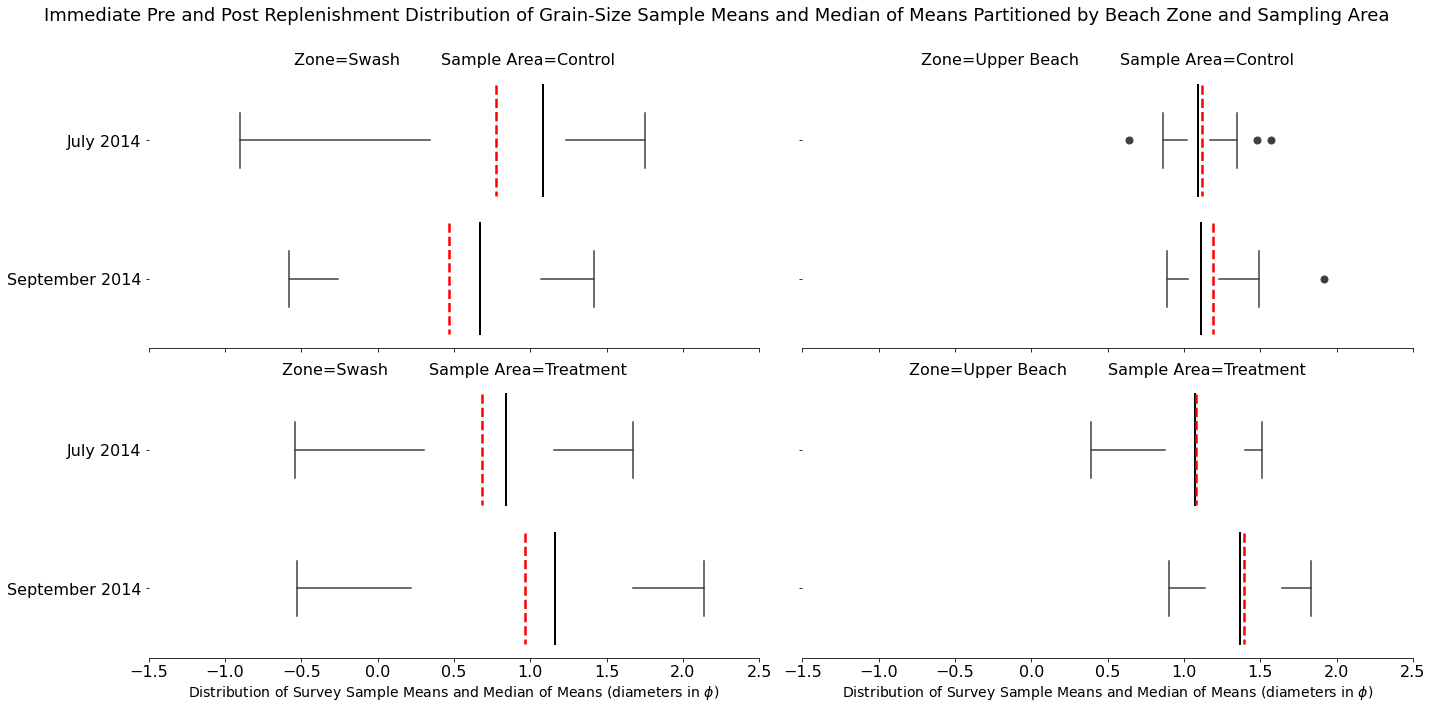

In [18]:
X = df.loc[((df['survey'] == '07 2014') | (df['survey'] == '09 2014'))]   #& (df['area'] == 'Control')

meanlineprops = dict(linestyle='--', linewidth=2.5, color='red')
medianlineprops = dict(linestyle='-', linewidth=2.0, color='black')
flierprops = dict(marker='o', markersize=7)
#boxprops = dict(fill)

my_colors = ["#9b59b6", "#3498db", "#2ecc71", "#006a4e"]
g = sns.catplot(x='FW_phi_mean',  y='survey', row='area', col='zone', data=X, kind='box', orient='h', notch=False, showfliers=True, \
            flierprops=flierprops, showbox=False, showmeans=True, meanline=True, meanprops=meanlineprops, medianprops=medianlineprops,\
                height=5, aspect=2.0, legend=True)

(g.despine(left=True)
  .set_axis_labels('Distribution of Survey Sample Means and Median of Means (diameters in $\phi$)', '', size=14)
  .set_xticklabels(size = 16)
  .set_yticklabels(['July 2014','September 2014'], size =16)
  .set_titles('Zone={col_name}        Sample Area={row_name}', size=16)
)

ax = g.axes
#k = ax[0,0].patch #.artists
#k.set_facecolor('#9b59b6')
    
g.fig.suptitle('Immediate Pre and Post Replenishment Distribution of Grain-Size Sample Means and Median of Means Partitioned by Beach Zone and Sampling Area\n', fontsize=18)

plt.tight_layout()
#plt.savefig(plot_path+'BoxPlots_2014_Comparisons.pdf')
;

### Grain-size distribution differences averaged before and after 1 year

''

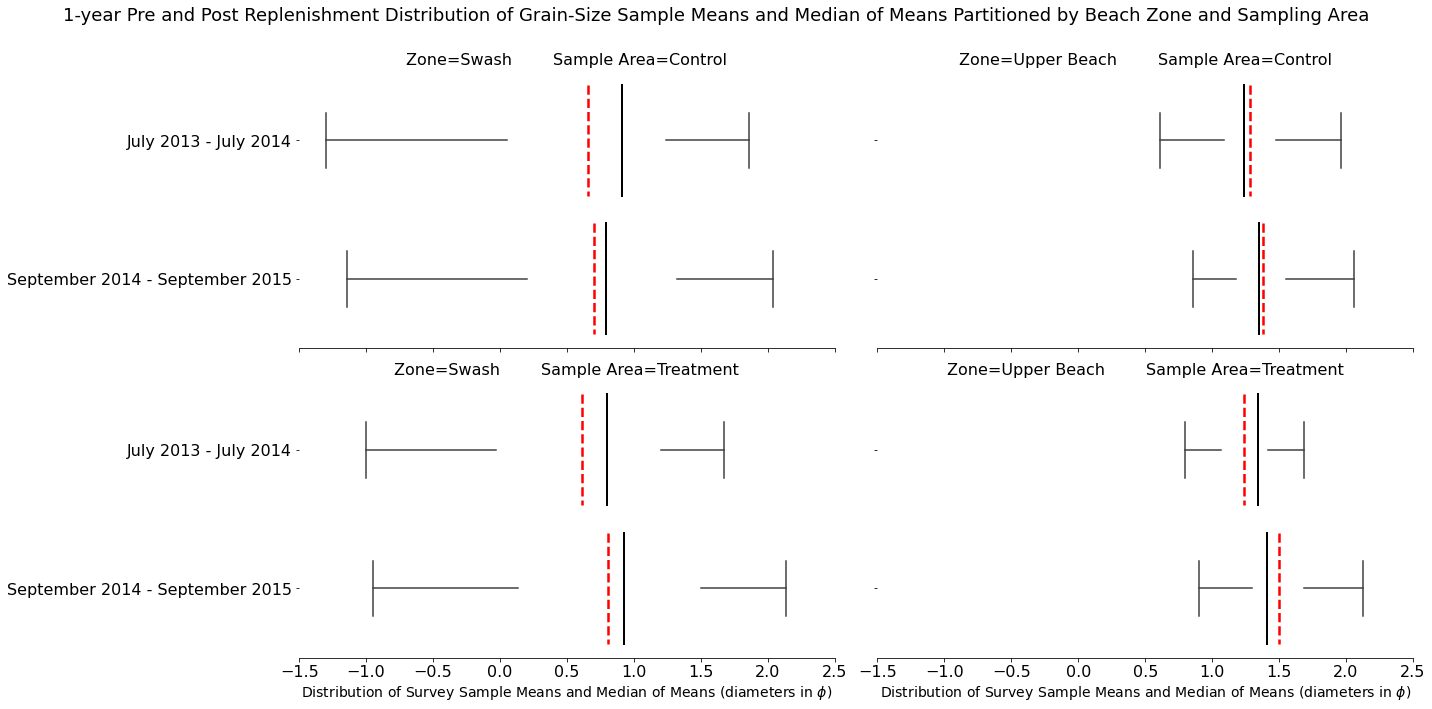

In [19]:
meanlineprops = dict(linestyle='--', linewidth=2.5, color='red')
medianlineprops = dict(linestyle='-', linewidth=2.0, color='black')
flierprops = dict(marker='o', markersize=7)
#boxprops = dict(fill)

# '2013-07-01T00:00:00.000000000'     '2015-10-20T00:00:00.000000000',
X = df.loc[((df['iso_date'] >= '2013-07-01T00:00:00.000000000') & (df['iso_date'] <= '2014-07-15T00:00:00.000000000') \
            | (df['iso_date'] >= '2014-09-29T00:00:00.000000000') & (df['iso_date'] <= '2015-10-20T00:00:00.000000000'))].copy()
X.loc[(df['iso_date'] <= '2014-07-15T00:00:00.000000000'), 'epoch'] = ' Pre-replenishment'
X.loc[(df['iso_date'] > '2014-07-15T00:00:00.000000000'),'epoch'] = 'Post-replenishment'

g = sns.catplot(x='FW_phi_mean',  y='epoch', row='area', col='zone', data=X, kind='box', orient='h', notch=False, showfliers=False, \
            flierprops=flierprops, showbox=False, showmeans=True, meanline=True, meanprops=meanlineprops, medianprops=medianlineprops,\
                height=5, aspect=2.0, legend=True)

(g.despine(left=True)
  .set_axis_labels('Distribution of Survey Sample Means and Median of Means (diameters in $\phi$)', '', size=14)
  .set_xticklabels(size = 16)
  .set_yticklabels(['July 2013 - July 2014','September 2014 - September 2015'], size =16)
  .set_titles('Zone={col_name}        Sample Area={row_name}', size=16)
)
g.fig.suptitle('1-year Pre and Post Replenishment Distribution of Grain-Size Sample Means and Median of Means Partitioned by Beach Zone and Sampling Area\n', fontsize=18)

plt.tight_layout()
plt.savefig(plot_path+'BoxPlots_1yr_Comparisons.pdf')
;

### Grain-size distribution differences averaged before and after 2 years

''

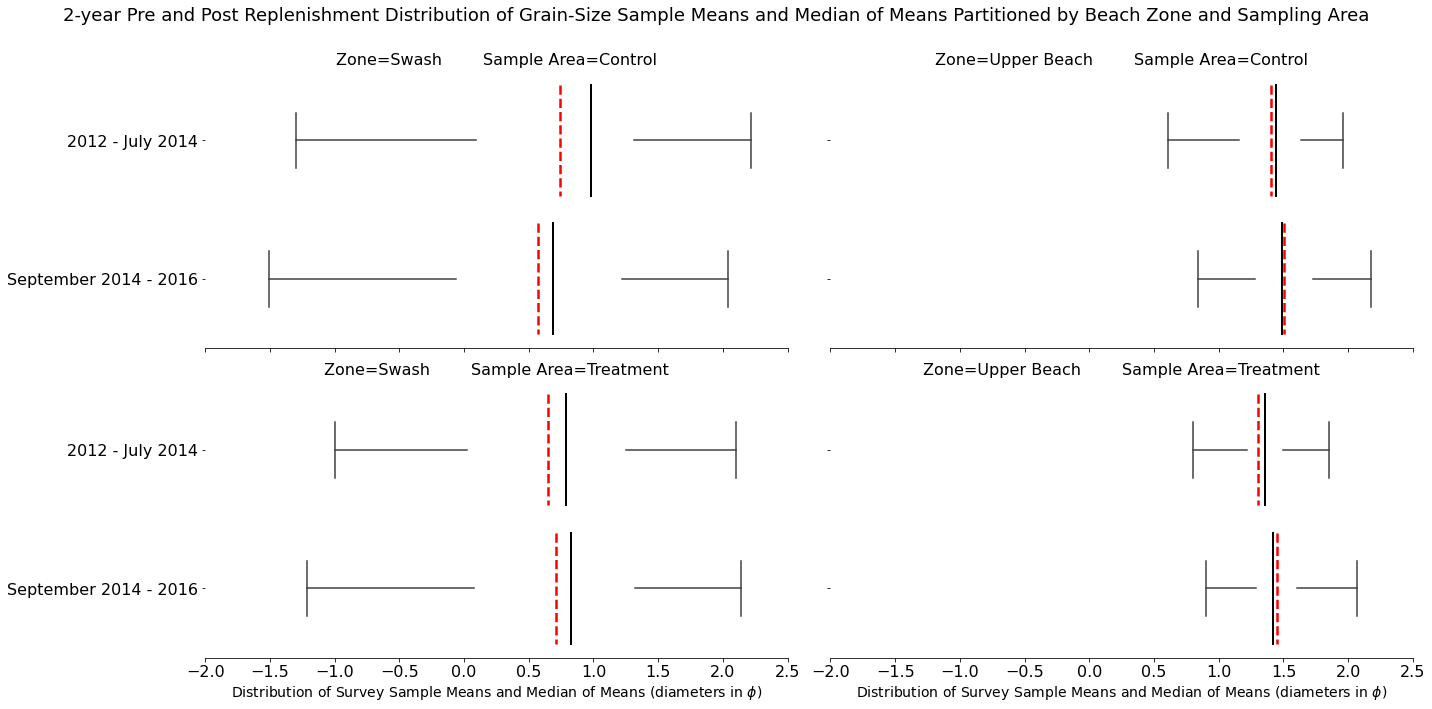

In [20]:
meanlineprops = dict(linestyle='--', linewidth=2.5, color='red')
medianlineprops = dict(linestyle='-', linewidth=2.0, color='black')
flierprops = dict(marker='o', markersize=7)
#boxprops = dict(fill)

X = df.loc[((df['iso_date'] <= '2014-07-15T00:00:00.000000000') | (df['iso_date'] <= '2016-10-13T00:00:00.000000000'))].copy()
X.loc[(df['iso_date'] <= '2014-07-15T00:00:00.000000000'), 'epoch'] = 'Pre-replenishment'
X.loc[(df['iso_date'] > '2014-07-15T00:00:00.000000000') & (df['iso_date'] <= '2016-10-13T00:00:00.000000000'),\
      'epoch'] = 'Post-replenishment'

g = sns.catplot(x='FW_phi_mean',  y='epoch', row='area', col='zone', data=X, kind='box', orient='h', notch=False, showfliers=False, \
            flierprops=flierprops, showbox=False, showmeans=True, meanline=True, meanprops=meanlineprops, medianprops=medianlineprops,\
                height=5, aspect=2.0, legend=True)

(g.despine(left=True)
  .set_axis_labels('Distribution of Survey Sample Means and Median of Means (diameters in $\phi$)', '', size=14)
  .set_xticklabels(size = 16)
  .set_yticklabels(['2012 - July 2014','September 2014 - 2016'], size =16)
  .set_titles('Zone={col_name}        Sample Area={row_name}', size=16)
)
g.fig.suptitle('2-year Pre and Post Replenishment Distribution of Grain-Size Sample Means and Median of Means Partitioned by Beach Zone and Sampling Area\n', fontsize=18)

plt.tight_layout()
plt.savefig(plot_path+'BoxPlots_2yr_Comparisons.pdf')
;

''

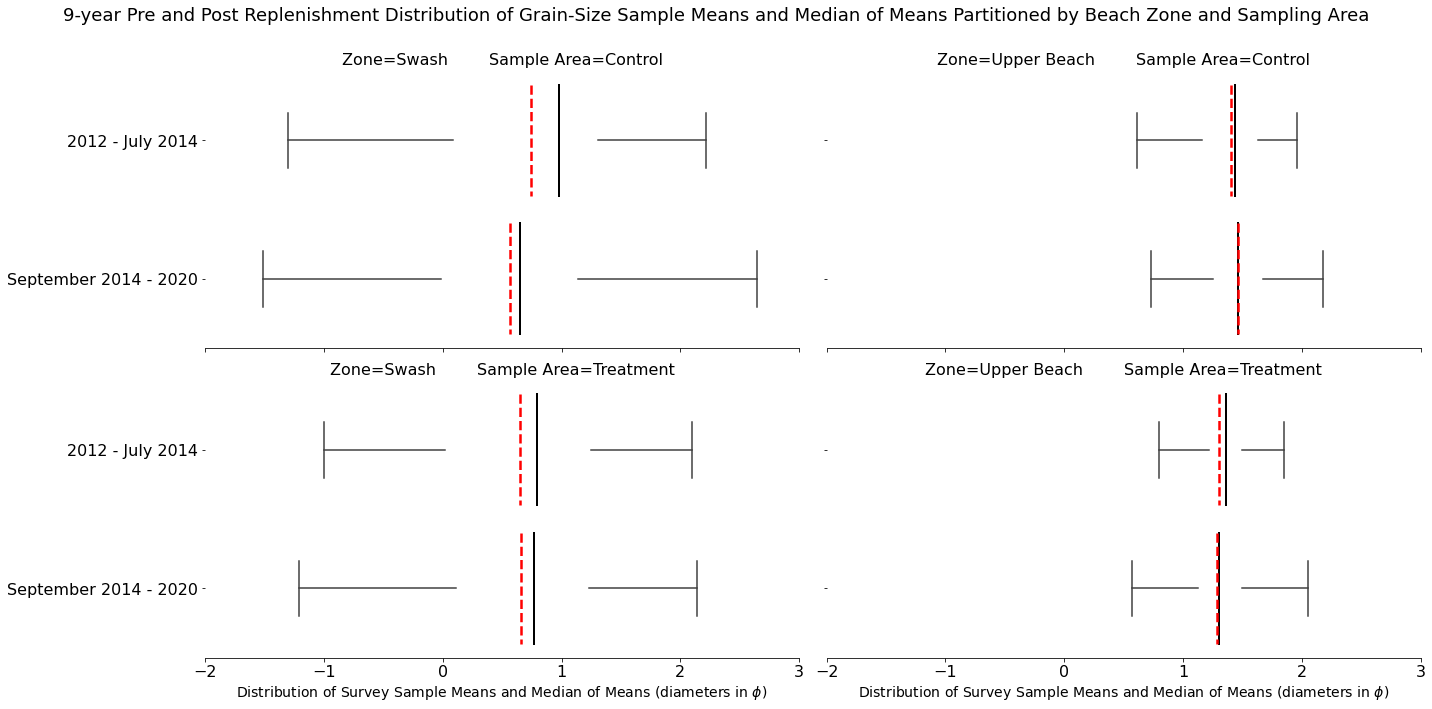

In [21]:
meanlineprops = dict(linestyle='--', linewidth=2.5, color='red')
medianlineprops = dict(linestyle='-', linewidth=2.0, color='black')
flierprops = dict(marker='o', markersize=7)
#boxprops = dict(fill)

g = sns.catplot(x='FW_phi_mean',  y='epoch', row='area', col='zone', data=df, kind='box', orient='h', notch=False, showfliers=False, \
            flierprops=flierprops, showbox=False, showmeans=True, meanline=True, meanprops=meanlineprops, medianprops=medianlineprops,\
                height=5, aspect=2.0, legend=True)

(g.despine(left=True)
  .set_axis_labels('Distribution of Survey Sample Means and Median of Means (diameters in $\phi$)', '', size=14)
  .set_xticklabels(size = 16)
  .set_yticklabels(['2012 - July 2014','September 2014 - 2020'], size =16)
  .set_titles('Zone={col_name}        Sample Area={row_name}', size=16)
)
g.fig.suptitle('9-year Pre and Post Replenishment Distribution of Grain-Size Sample Means and Median of Means Partitioned by Beach Zone and Sampling Area\n', fontsize=18)

plt.tight_layout()
#plt.savefig(plot_path+'BoxPlots_All_Surveys_Comparisons.pdf')
;

### Add PERMANOVA Results to confirm overall no significant differences seen...

### Build Sub-Epochs for different periods to compare:

- July 2014 epoch_p1  & September 2014 epoch_P1
- July 2013 - July 2014 epoch_p2  & September 2014 - September/October 2015 epoch_P2
- July 2012 - July 2014 epoch_p3 & September 2014 - October 2016 epoch_P3
- 2012 - July 2014 prenourishment & September 204 - October 2020 postnourishment

In [22]:
df['iso_date'].unique()

array(['2012-04-01T00:00:00.000000000', '2012-07-01T00:00:00.000000000',
       '2012-10-01T00:00:00.000000000', '2013-04-01T00:00:00.000000000',
       '2013-07-01T00:00:00.000000000', '2013-10-01T00:00:00.000000000',
       '2014-04-01T00:00:00.000000000', '2014-07-01T00:00:00.000000000',
       '2014-07-15T00:00:00.000000000', '2014-09-29T00:00:00.000000000',
       '2014-10-01T00:00:00.000000000', '2015-04-01T00:00:00.000000000',
       '2015-04-28T00:00:00.000000000', '2015-07-01T00:00:00.000000000',
       '2015-10-01T00:00:00.000000000', '2015-10-20T00:00:00.000000000',
       '2016-04-01T00:00:00.000000000', '2016-05-01T00:00:00.000000000',
       '2016-07-01T00:00:00.000000000', '2016-10-01T00:00:00.000000000',
       '2016-10-13T00:00:00.000000000', '2017-04-01T00:00:00.000000000',
       '2017-04-27T00:00:00.000000000', '2017-08-01T00:00:00.000000000',
       '2017-08-26T00:00:00.000000000', '2017-10-01T00:00:00.000000000',
       '2018-04-01T00:00:00.000000000', '2018-08-01

In [23]:
df.loc[df['iso_date'] == '2014-07-01T00:00:00.000000000', 'sub_epoch'] = 'epoch_p1'
df.loc[df['iso_date'] == '2014-09-29T00:00:00.000000000', 'sub_epoch'] = 'epoch_P1'
df.loc[(df['iso_date'] >= '2013-07-01T00:00:00.000000000') & (df['iso_date'] <= '2014-07-01T00:00:00.000000000'), 'sub_epoch'] = 'epoch_p2'
df.loc[(df['iso_date'] >= '2014-09-29T00:00:00.000000000') & (df['iso_date'] <= '2015-10-01T00:00:00.000000000'), 'sub_epoch'] = 'epoch_P2'
df.loc[(df['iso_date'] >= '2012-07-01T00:00:00.000000000') & (df['iso_date'] <= '2014-07-01T00:00:00.000000000'), 'sub_epoch'] = 'epoch_p3'
df.loc[(df['iso_date'] >= '2014-09-29T00:00:00.000000000') & (df['iso_date'] <= '2016-07-01T00:00:00.000000000'), 'sub_epoch'] = 'epoch_P3'

In [12]:
gbo = df.groupby(['epoch','survey','zone','area'], sort=False).agg({
    '%gravels':'mean',
    '%c_sands':'mean',
    '%m_sands':'mean',
    '%f_sands':'mean'
}).reset_index()
#gbo

### Size Fraction Plots - Upper Beach

In [ ]:
# create a grouped supratidal object that merges on survey and sample:

stgrp = supratidal.groupby(['survey','sample']).agg({
    'season':'first',
    'transect':'first',
    'area':'first',
    'epoch':'first',
    'FW_phi_mean':'mean',
    'FW_phi_sort':'mean',
    'FW_phi_skew':'mean',
    'FW_phi_kurt':'mean',
    '%vc_gravel':'mean',
    '%c_gravel':'mean',
    '%m_gravel':'mean',
    '%f_gravel':'mean',
    '%vf_gravel':'mean',
    '%vc_sand':'mean',
    '%c_sand':'mean',
    '%m_sand':'mean',
    '%f_sand':'mean',
    '%vf_sand':'mean'
})

stgrp.reset_index(drop=False, inplace=True)
stgrp.sort_values(by=['survey'])
;

## Add $\phi$ to mm conversions for FW mean and sorting:

In [ ]:
df['FW_mm_mean'] = 2**((-1)*df['FW_phi_mean'])
df['FW_mm_sort'] = 2**((-1)*df['FW_phi_sort'])

## Create a dataframe grouped on season, survey, and area:

to be exported to a csv for nMDS and P-ANOVA processing in R

In [ ]:
# create a grouped object that merges on season, survey and area:

dfgrp = df.groupby(['season','survey','area']).agg({
    'epoch':'first',
    'FW_phi_mean':'mean',
    'FW_phi_sort':'mean',
    'FW_phi_skew':'mean',
    'FW_phi_kurt':'mean',
    '%vc_gravel':'mean',
    '%c_gravel':'mean',
    '%m_gravel':'mean',
    '%f_gravel':'mean',
    '%vf_gravel':'mean',
    '%vc_sand':'mean',
    '%c_sand':'mean',
    '%m_sand':'mean',
    '%f_sand':'mean',
    '%vf_sand':'mean',
    'FW_mm_mean':'mean',
    'FW_mm_sort':'mean'
})

dfgrp.reset_index(drop=False, inplace=True)
dfgrp.sort_values(by=['survey'], inplace=True)

dfgrp.to_csv(data_path+'Sediment_Data_to_R.csv', index=False)

In [ ]:
dfgrp

In [ ]:
## Compaction

In [ ]:
df = load_data(data_path, data_file_name)